# MVP: *Machine Learning & Analytics*
**Autor:** FILIPE CASTELO BRANCO DE SOUZA  

**Data:** 28/09/2025

**Matrícula:** 4052025001950

**Dataset:** [Histórico de Alunos de CC/UFRJ](https://github.com/filipecbs/mvpPucRioSprintMachineLearning/blob/main/historico_alunos_cc_ufrj.xlsx)

# Estudo sobre Evasão vs. Conclusão — CC/UFRJ

**Problema de negócio.** Antecipar, ainda nos **N primeiros períodos** do curso (projeto com _N_=2, primeiro ano), quais estudantes apresentam **alto risco de evasão** para que a coordenação possa **intervir precocemente** (contato, monitoria, tutoria, etc). Trata-se de um problema de **classificação binária**: `label=1` (evasão/cancelamento) vs. `label=0` (conclusão).

**Objetivo analítico.** Construir um modelo supervisionado que **ranqueie** os alunos por probabilidade de evasão, maximizando **qualidade no topo** (PR-AUC) e mantendo **alto recall** (minimizando falsos negativos), pois não reconhecer um aluno que evadirá tem **custo alto** para a instituição.

**Premissas / hipóteses.**
- **Sinal precoce** em desempenho: reprovações, notas baixas e baixa aderência à grade obrigatória logo no início devem **aumentar** o risco de evasão.
- **Intensidade de progresso** (matérias obrigatórias concluídas até N) deve **reduzir** o risco.
- **Aluno ingressante por ENEM**: a **nota** (quando disponível) pode correlacionar com desempenho inicial; a **ausência** da nota não deve ser tratada como erro, mas como informação faltante a ser imputada no pipeline.
- **Modalidade de cota** pode ter efeito, mas espera-se menor que o de desempenho acadêmico direto.

**Restrições / critérios de seleção de dados.**
- Utilizada somente **informação disponível até N** (evita vazamento do futuro), salvo status final de matrícula (Conclusão x Evasão).
- Não foram considerados alunos que **ainda estão matriculados** (matrícula Ativa).
- Excluídos alunos que **não atingiram N períodos** na construção das _features_.
- Conjunto focado em **um curso específico** (Bacharelado em CC/UFRJ), com **períodos corridos**.
- **Reprodutibilidade**: `SEED=42`, documentação das transformações e salvamento dos artefatos.

**Descrição do dataset (após _feature engineering_).**
- **Amostras**: 482 estudantes (positivos ≈ **65,8%** `label=1`).
- **Rótulo**: `label` binário já definido no processo de rotulagem institucional.
- **Atributos de entrada (exemplos)**  
  - Desempenho/agregados até N: `qtd_matriculas_ate_N`, `qtd_reprov_ate_N`, `pct_reprov_ate_N`, `media_notas_ate_N`,  
    `qtd_concl_obrigatorias_ate_N`, `pct_concl_obrigatorias_ate_N`,  
    `qtd_notas_baixas_lt3_ate_N`, `qtd_notas_baixas_lt5_ate_N`, `pct_notas_baixas_lt3_ate_N`, `pct_notas_baixas_lt5_ate_N`, `qtd_adiantadas_ate_N`.
  - Dados de ingresso/administrativos: `notaEnem` (≈ **30,5%** faltante), `modalidadeCota`.
  - Demográfico simples: `sexo`.
- **Higiene de colunas.** Removido `aluno_id` (identificador), `label` e duas colunas **constantes** sem informação (`media_missing_flag`, `reached_N_flag`).  
  Resultado: **14 colunas** em `X` (numéricas + categóricas).
- **Valores ausentes.** Concentram-se em `notaEnem` (~30,5%); os demais atributos não possuem NA. A imputação (mediana/mais frequente) e a codificação (One-Hot) serão feitas **dentro do pipeline** para não vazar informação.

# Geração do Dataset — parâmetros e escopo

Esta seção documenta a construção do dataset analítico a partir da planilha institucional de histórico acadêmico. Define-se a parametrização do processo de construção das *features* e aplicam-se filtros operacionais para garantir consistência do rótulo:

- **Parâmetros**: horizonte **N** (períodos analisados), tipo de contagem (**corridos** vs. **matriculados**), filtros opcionais (curso/forma/intervalo de ingresso) e regras de exclusão.
- **Grade obrigatória** e **equivalências**: regras de mapeamento que identificam quais disciplinas contam como obrigatórias até _N_.
- Conversão do **histórico textual** em tabela normalizada de matrículas (*explode*).
- Definição de **período relativo** por aluno (corridos × matriculados) para evitar vazamento temporal.
- **Auditorias rápidas** (NA%, formatos, distribuição de status Aprov/Reprov) para sanidade dos dados.
- Saída final: `features_…csv` com atributos até _N_ e rótulo binário (**0=conclusão**, **1=evasão**), reprodutível a partir deste notebook.

## Imports e Configurações de Ambiente



In [9]:
# 1) Imports
# Importações básicas, configuração de semente/ambiente e limites de exibição.

import os, re, json, math, random
import numpy as np
import pandas as pd

# Configurações de ambiente
SEED = 42
random.seed(SEED); np.random.seed(SEED)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 160)


## Parâmetros

In [10]:
# 2) Parâmetros

# Obrigatórios
N_PERIODOS    = 2                      # int > 0
TIPO_PERIODO  = "corridos"             # "corridos" | "matriculados"

# Listas para códigos de curso
# Se None ou lista vazia => não filtra por aquele eixo.
CODIGOS_INGRESSO = ["3101070000"]                 # ou None / []
CODIGOS_ATUAL    = ["3101070000","3109000100"]    # ou None / []

# Opcionais (None para não filtrar)
PERIODO_INGRESSO_MIN = "2010/1"        # ex.: "2010/1" | None
PERIODO_INGRESSO_MAX = None            # ex.: "2022/2" | None
FORMAS_INGRESSO      = ["Vestibular","SiSU - Sistema de Seleção Unificada"]  # ou None

# Exclusões
EXCLUIR_NAO_ATINGIU_N = True # caso o estudante não tenha cursado N períodos, excluir do dataset
EXTRAS_MAX_COUNT = 5       # excluir aluno com mais de N matérias extras cursadas
EXTRAS_MAX_PROP  = 0.60    # excluir aluno cuja razão entre matérias extras/esperadas é maior que N

# Excluir alunos com 0 aprovações até N
EXCLUIR_ZERO_APROVACAO_ATE_N = True

# Treinar somente com rótulo conhecido (Concluído/Cancelado)
FILTRAR_SOMENTE_ROTULADOS = True

# Entrada
ARQUIVO_XLSX = "https://raw.githubusercontent.com/filipecbs/mvpPucRioSprintMachineLearning/main/historico_alunos_cc_ufrj.xlsx"
ABA = "segmentohistorico"

## Matérias Obrigatórias e Equivalências

Define-se a lista de disciplinas **obrigatórias por período** e as **equivalências** aceitas.  
As regras refletem decisões de negócio: certas disciplinas alternativas ou combinações contam como equivalentes às obrigatórias.

In [11]:
# 3) Matérias obrigatórias e equivalências

materias_obrigatorias = {
    1: ['MAB111','MAB112','MAB120','MAB624','MAE111'],
    2: ['MAB113','MAB240','MAB245','MAB352','MAE992'],
    3: ['FIW125','MAB115','MAB116','MAB123','MAB353','MAE993'],
    4: ['FIW230','MAB117','MAB230','MAB368','MAE994'],
}

# ALT -> [TARGETS]  (se aluno cursou ALT, conta como TARGET(S))
single_map = {
    'MAB243': ['MAB116'],
    'MAE121': ['MAE992'],
    'MAE231': ['MAE993'],
    'MAE241': ['MAE994'],
    'NCG007': ['MAB626'],
    'NCG008': ['MAB627'],
    'NCG009': ['MAB628'],
    'NCG010': ['MAB629'],
    'MAB231': ['MAB230'],
    'MAC118': ['MAE111'],
    'MAC128': ['MAE992'],
    'MAC238': ['MAE993'],
    'MAC248': ['MAE994'],
}

# Quando TODAS as 'alts' aparecem, conta-se também o 'target' (algumas matérias precisam de mais de uma matéria cursada para conseguir a equivalência)
combo_rules = [
    {'alts': set(['FIT111','FIT121']), 'target': 'FIW125'},
    {'alts': set(['MAE115','MAE125']), 'target': 'MAB115'},
    {'alts': set(['CMT012','MAB121']), 'target': 'MAB120'},
]


## Helpers
Agrupam-se funções para:
- normalizar e ordenar períodos (`periodo_to_index`, `rel_periodo`);
- *parsing* do histórico textual para tabela “aluno × matrícula”;
- auditorias rápidas (status Aprov/Reprov) e inspeção pontual de alunos;
- *snapshots* de NA%, dtypes e faixas para checagens de sanidade.

In [12]:
# 4) Helpers — parsing, equivalências, períodos, utilitários

def periodo_to_index(p: str) -> int:
    """
    Converte 'YYYY/S' em índice crescente (YYYY*2 + (S-1)).
    Regras:
      - aceita S em {0,1,2}; '/0' é tratado como '/1' (equivalências/transferências).
      - lança ValueError se formato inválido.
    Ex.: 2010/1 -> 4020 ; 2010/2 -> 4021
    """
    y_s = str(p).strip().split("/")
    if len(y_s) != 2:
        raise ValueError(f"Período inválido: {p}")
    y, s = y_s[0].strip(), y_s[1].strip()
    y = int(y); s = int(s)
    if s == 0:
        s = 1
    if s not in (1, 2):
        raise ValueError(f"Semestre inválido em '{p}' (esperado 0, 1 ou 2)")
    return y*2 + (s-1)

def map_label_curso(situacao) -> float:
    """
    Label do curso (nível aluno):
      - 0.0 se string contém 'conclu' (Concluído/Conclusão).
      - 1.0 se contém 'cancel' (Cancelado).
      - NaN caso contrário (ativo/censurado).
    """
    if situacao is None or (isinstance(situacao, float) and np.isnan(situacao)):
        return float("nan")
    t = str(situacao).lower()
    if "conclu" in t: return 0.0
    if "cancel" in t: return 1.0
    return float("nan")

# Regex do histórico
_DISC_RE = re.compile(
    r'(\d{4}/\d)\s*-\s*([A-Z0-9]{3,7})\s+([^-]+?)\s*-\s*([0-9T\s]{0,4})\s*-\s*(.+)'
)

def parse_disciplinas_texto(historico_texto):
    """
    Converte 'disciplinasCursadas' (texto multiline) em lista de dicts:
      - periodo_cursado : 'YYYY/S' (S∈{0,1,2}; /0 será tratado como /1 ao calcular índice)
      - cod_disc        : código da disciplina (str)
      - nome_disc       : nome textual da disciplina (str; útil p/ auditoria)
      - status_disc     : 'Aprovado', 'Reprovado', 'Repr falta/média', etc.
      - nota            : float 0–100 ou NaN
    Regras de nota:
      - vazio ou 'T' -> NaN
      - se numérico <= 10, converte para 0–100 (x10)
    """
    if historico_texto is None or (isinstance(historico_texto, float) and np.isnan(historico_texto)):
        return []
    txt = str(historico_texto)
    out = []
    for m in _DISC_RE.finditer(txt):
        periodo_cursado = m.group(1)
        cod_disc = m.group(2).strip().upper()
        nome_disc = m.group(3).strip()
        nota_raw = m.group(4).strip()
        status_disc = m.group(5).strip()

        if nota_raw == "" or nota_raw.upper() == "T":
            nota = np.nan
        else:
            try:
                nota = float(nota_raw.replace(",", "."))
                if nota <= 10:
                    nota = nota * 10.0
            except Exception:
                nota = np.nan

        out.append({
            "periodo_cursado": periodo_cursado,
            "cod_disc": cod_disc,
            "nome_disc": nome_disc,
            "status_disc": status_disc,
            "nota": nota
        })
    return out

def explodir_matriculas_de_alunos(df_alunos_filtrado: pd.DataFrame) -> pd.DataFrame:
    """
    Explode 'disciplinasCursadas' (nível aluno) -> tabela de matrículas (nível disciplina).
    Saída:
      - aluno_id, periodo_cursado, cursado_index, cod_disc, nome_disc, status_disc, nota
    """
    rows = []
    for _, r in df_alunos_filtrado.iterrows():
        aluno_id = int(r["aluno_id"])
        for it in parse_disciplinas_texto(r.get("disciplinasCursadas")):
            try:
                ci = periodo_to_index(it["periodo_cursado"])
            except Exception:
                ci = None
            rows.append({
                "aluno_id": aluno_id,
                "periodo_cursado": it["periodo_cursado"],
                "cursado_index": ci,
                "cod_disc": it["cod_disc"],
                "nome_disc": it["nome_disc"],
                "status_disc": it["status_disc"],
                "nota": it["nota"],
            })
    return pd.DataFrame(rows)

def remap_periodos_matriculados(cursado_index_series: pd.Series) -> pd.Series:
    """
    Remapeia os valores distintos de 'cursado_index' para 1..k preservando a ordem.
    Usado quando TIPO_PERIODO = 'matriculados'.
    """
    uniq = sorted(pd.Series(cursado_index_series).dropna().unique())
    mapa = {idx: i+1 for i, idx in enumerate(uniq)}
    return cursado_index_series.map(mapa)

def construir_rel_periodo(mats: pd.DataFrame, alunos: pd.DataFrame, tipo_periodo: str) -> pd.DataFrame:
    """
    Adiciona `rel_periodo` à tabela de matrículas:
      - 'corridos'    : rel = cursado_index - ingresso_index + 1 (contagem por calendário)
      - 'matriculados': remapeia períodos cursados distintos por aluno para 1..k
    """
    assert tipo_periodo in ("corridos", "matriculados")
    merged = mats.merge(alunos[["aluno_id", "ingresso_index"]], on="aluno_id", how="left")
    if tipo_periodo == "corridos":
        merged["rel_periodo"] = (merged["cursado_index"] - merged["ingresso_index"] + 1)
    else:
        merged["rel_periodo"] = (
            merged.groupby("aluno_id", group_keys=False)["cursado_index"]
                  .apply(remap_periodos_matriculados)
        )
    return merged

# ---- Helpers de grade/equivalências ----

def esperadas_ate_N(N: int) -> set:
    """Retorna o conjunto de códigos obrigatórios esperados até N (inclui 1..N)."""
    s = set()
    for k, v in materias_obrigatorias.items():
        if int(k) <= int(N):
            s.update(v)
    return set(map(str, s))

def expandir_equivalencias(codigos_aprovados: set) -> set:
    """
    Expande aprovadas:
      (1) single_map: ALT -> TARGETS
      (2) combo_rules: se alts ⊆ aprovadas, adiciona target
    """
    aprov = set(map(str, codigos_aprovados))
    exp = set(aprov)
    for alt, targets in single_map.items():
        if alt in aprov:
            exp.update(map(str, targets))
    for rule in combo_rules:
        if rule['alts'].issubset(exp):
            exp.add(str(rule['target']))
    return exp


In [13]:
# 4B) Helpers de auditoria (checagens rápidas e inspeção de aluno)

def auditar_status_matriculas(mats: pd.DataFrame, top_k: int = 15):
    """
    Mostra um resumo dos 'status_disc':
      - Top frequências (texto original).
      - Totais mapeados como 'aprov' (contém 'aprov') e 'reprov' (contém 'repr').
      - Quais sobram fora desses grupos (se houver).
    Retorna um dicionário com totais.
    """
    if mats.empty:
        print("Sem matrículas para auditar.")
        return {"total": 0, "aprov": 0, "repr": 0, "outros": 0, "unicos": []}

    s = mats["status_disc"].astype(str).str.strip()
    s_lower = s.str.lower()

    print("Top status (texto original):")
    print(s.value_counts().head(top_k).to_string())

    mask_ap = s_lower.str.contains("aprov")
    mask_rp = s_lower.str.contains("repr")   # 'reprovado' e 'repr falta/média'
    mask_outros = ~(mask_ap | mask_rp)

    outros = s[mask_outros].value_counts()
    print("\nStatus não mapeados (amostra):")
    if outros.empty:
        print("Nenhum — apenas Aprov/Reprov detectados.")
    else:
        print(outros.head(top_k).to_string())

    resumo = {
        "total": int(len(s)),
        "aprov": int(mask_ap.sum()),
        "repr": int(mask_rp.sum()),
        "outros": int(mask_outros.sum()),
        "unicos": sorted(set(s_lower.unique()))
    }
    print("\nResumo:", resumo)
    return resumo

def tem_somente_aprov_reprov(mats: pd.DataFrame) -> bool:
    """Retorna True se não houver status fora de 'aprov'/'repr'. Também imprime o resumo."""
    r = auditar_status_matriculas(mats, top_k=15)
    ok = (r.get("outros", 1) == 0)
    print(f"\nSomente Aprov/Reprov? {ok}")
    return ok

def inspecionar_aluno(aluno_id: int, mats_rel: pd.DataFrame, debug_df: pd.DataFrame, N: int, max_linhas: int = 25):
    """
    Inspeciona um aluno específico:
      - Mostra suas matrículas em 1..N (mats_rel).
      - Mostra listas de aprovadas/esperadas/extras (debug_df).
    """
    print(f"\n=== Inspeção do aluno {aluno_id} (1..{N}) ===")
    sub = mats_rel[(mats_rel["aluno_id"] == aluno_id) & (mats_rel["rel_periodo"].between(1, N, inclusive="both"))]
    if sub.empty:
        print("Sem linhas de matrícula em 1..N para este aluno.")
    else:
        cols = ["aluno_id","periodo_cursado","cursado_index","rel_periodo","cod_disc","nome_disc","status_disc","nota"]
        print(f"Total de linhas em 1..{N}: {len(sub)} (mostrando até {max_linhas})")
        display(sub[cols].head(max_linhas))

    dbg = debug_df.loc[debug_df["aluno_id"] == aluno_id]
    if not dbg.empty:
        row = dbg.iloc[0]
        print("\nListas do debug:")
        print(" - Aprovadas:", row["aprovadas_list"])
        print(" - Esperadas:", f"(len={len(row['esperadas_list'])})", row["esperadas_list"] if len(row["esperadas_list"])<=10 else row["esperadas_list"][:10] + ["..."])
        print(" - Extras   :", row["extras_list"])
    else:
        print("Aluno não encontrado no debug_df.")


In [14]:
# 4C) Helpers de diagnóstico (NA%, dtypes, faixas)

CONTADORES = [
    "qtd_matriculas_ate_N","qtd_reprov_ate_N",
    "qtd_notas_baixas_lt3_ate_N","qtd_notas_baixas_lt5_ate_N",
    "qtd_concl_obrigatorias_ate_N","qtd_adiantadas_ate_N",
]

# razões derivadas de contadores
TAXAS = [
    "pct_reprov_ate_N","pct_notas_baixas_lt3_ate_N",
    "pct_notas_baixas_lt5_ate_N","pct_concl_obrigatorias_ate_N",
]

def snapshot_numericos(df: pd.DataFrame, nome: str = "snapshot"):
    num = df.select_dtypes(include=[np.number])
    if num.empty:
        print(f"[{nome}] Nenhuma coluna numérica encontrada.")
        return
    print(f"\n[{nome}] Resumo numéricos (count/mean/std/min/p1/p5/p25/50%/p75/p95/p99/max):")
    desc = num.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
    display(desc)

    print(f"\n[{nome}] Top 15 NA% por coluna numérica:")
    na_pct = (num.isna().mean()*100).sort_values(ascending=False)
    print(na_pct.head(15).round(2).to_string())

def resumo_na_cols(df: pd.DataFrame, cols: list, titulo: str):
    cols = [c for c in cols if c in df.columns]
    if not cols:
        print(f"{titulo}: colunas não presentes.")
        return
    print(f"\n{titulo}:")
    na_pct = (df[cols].isna().mean()*100).round(2).sort_values(ascending=False)
    print(na_pct.to_string())


## Leitura e Validação do xlsx
Carrega-se a aba de histórico e verificam-se **colunas obrigatórias**, *casts* necessários e o **índice de ingresso** (`ingresso_index`), que será usado para montar o período relativo por aluno.

In [15]:
# 5) Leitura e validação do XLSX

colunas_obrigatorias = [
    "periodoIngressoUFRJ",
    "cursoIngressoUFRJ",
    "codCursoIngresso",
    "cursoAtual",
    "codCursoAtual",
    "formaIngresso",
    "situacaoMatriculaAtual",
    "notaEnem",
    "modalidadeCota",
    "sexo",
    "disciplinasCursadas",
]

xls = pd.ExcelFile(ARQUIVO_XLSX)
assert ABA in xls.sheet_names, f"Aba '{ABA}' não encontrada. Abas existentes: {xls.sheet_names}"

alunos_raw = xls.parse(ABA)
faltantes = [c for c in colunas_obrigatorias if c not in alunos_raw.columns]
if faltantes:
    raise KeyError(f"Colunas obrigatórias faltando na planilha: {faltantes}")

# ID sequencial do aluno (não há student_id na planilha)
alunos_raw = alunos_raw.reset_index(drop=False).rename(columns={"index":"aluno_id"})
alunos_raw["aluno_id"] = alunos_raw["aluno_id"].astype(int)

# Tipos/casts
alunos_raw["codCursoIngresso"] = alunos_raw["codCursoIngresso"].astype(str)
alunos_raw["codCursoAtual"]    = alunos_raw["codCursoAtual"].astype(str)

# Índice do período de ingresso
alunos_raw["ingresso_index"] = alunos_raw["periodoIngressoUFRJ"].apply(lambda x: periodo_to_index(x))

print("Dimensão da planilha:", alunos_raw.shape)
display(alunos_raw.head(3))


Dimensão da planilha: (2705, 25)


,aluno_id,periodoIngressoUFRJ,cursoIngressoUFRJ,codCursoIngresso,cursoAtual,codCursoAtual,manutencaoDeVinculo,periodoIngressoCursoAtual,formaIngresso,situacaoMatriculaAtual,...,crPorPeriodo,craPorPeriodo,periodosIntegralizados,cargaHorariaAcumulada,CRA,periodosTrancados,periodosCancelados,periodosCRMenor3,reprovacoes,ingresso_index
0,0,2000/1,Bacharelado em Informática,3101020000,Bacharelado em Ciência da Computação,3101070000,0,2000/1,Vestibular,Cancelada por conclusão de curso,...,2000/1 - 3.8\n2000/2 - 5.7\n2001/1 - 5.6\n2001/2 - 7.2\n2002/1 - 7.4\n2002/2 - 7.5\n2003/1 - 6.6\n2003/2 - 5.6\n2004/1 - 5.2\n2004/2 - 4.2\n2005/1 - 5\n2005...,2000/1 - 3.9\n2000/2 - 4.8\n2001/1 - 5\n2001/2 - 5.7\n2002/1 - 6\n2002/2 - 6.2\n2003/1 - 6.3\n2003/2 - 6.2\n2004/1 - 6.2\n2004/2 - 6\n2005/1 - 5.9\n2005/2 -...,15,3180,6.2,NaN,NaN,NaN,2000/1 - MAA123 Algebra para Informatica - 021 - Reprovado media \n2000/1 - MAE111 Cálculo Infinitesimal I - 016 - Reprovado media \n2000/1 - MAE115 Cálculo...,4000
1,1,2000/1,Bacharelado em Informática,3101020000,Bacharelado em Ciência da Computação,3101070000,0,2000/1,Vestibular,Cancelada por conclusão de curso,...,2000/1 - 7.3\n2000/2 - 6.9\n2001/1 - 5.5\n2001/2 - 6.8\n2002/1 - 7.7\n2002/2 - 7.6\n2003/1 - 8.2\n2003/2 - 8.3\n2004/1 - 7.6\n2004/2 - 8.9,2000/1 - 7.4\n2000/2 - 7.1\n2001/1 - 6.6\n2001/2 - 6.6\n2002/1 - 6.8\n2002/2 - 6.9\n2003/1 - 7.1\n2003/2 - 7.2\n2004/1 - 7.3\n2004/2 - 7.4,11,3165,7.4,NaN,2005/1,NaN,2000/2 - MAE125 Álgebra Linear II - 040 - Reprovado media,4000
2,2,2000/1,Bacharelado em Informática,3101020000,Bacharelado em Ciência da Computação,3101070000,0,2000/1,Vestibular,Cancelada por conclusão de curso,...,2000/1 - 6.7\n2000/2 - 5.9\n2001/1 - 5.3\n2001/2 - 6.9\n2002/1 - 6.6\n2002/2 - 6.3\n2003/1 - 6.7\n2003/2 - 3.4\n2004/1 - 5.7\n2004/2 - 6.2\n2005/1 - 5.6\n20...,2000/1 - 6.7\n2000/2 - 6.3\n2001/1 - 5.9\n2001/2 - 6.1\n2002/1 - 6.2\n2002/2 - 6.2\n2003/1 - 6.3\n2003/2 - 6.1\n2004/1 - 6.1\n2004/2 - 6.1\n2005/1 - 6.1\n20...,15,3150,6.1,NaN,NaN,NaN,2000/2 - MAE121 Calculo Infinitesimal II - 034 - Reprovado media \n2000/2 - MAE125 Álgebra Linear II - 044 - Reprovado media \n2001/1 - FIT121 Física II - 0...,4000


## Filtro
Aplica-se a filtragem por códigos de curso (ingresso/atual), janela temporal de ingresso e formas de ingresso (quando especificadas). Em seguida, mapeia-se a situação final do aluno para o rótulo binário: **0 = concluído**, **1 = cancelado** (demais estados ficam como NaN e podem ser excluídos da modelagem, conforme parâmetro).

In [16]:
# 6) Filtro (curso/forma/ingresso) + Label

alunos = alunos_raw.copy()

# Normaliza tipo das colunas de código
alunos["codCursoIngresso"] = alunos["codCursoIngresso"].astype(str).str.strip()
alunos["codCursoAtual"]    = alunos["codCursoAtual"].astype(str).str.strip()

mask = pd.Series(True, index=alunos.index)

# Ingresso (lista opcional)
if isinstance(CODIGOS_INGRESSO, (list, tuple)) and len(CODIGOS_INGRESSO) > 0:
    cods_ingressos_validos = [str(c).strip() for c in CODIGOS_INGRESSO]
    mask &= alunos["codCursoIngresso"].isin(cods_ingressos_validos)

# Atual (lista opcional; se não houver, não filtra por atual)
if isinstance(CODIGOS_ATUAL, (list, tuple)) and len(CODIGOS_ATUAL) > 0:
    cods_atual_validos = [str(c).strip() for c in CODIGOS_ATUAL]
    mask &= alunos["codCursoAtual"].isin(cods_atual_validos)

# Janela de ingresso (opcional)
if PERIODO_INGRESSO_MIN is not None:
    min_idx = periodo_to_index(PERIODO_INGRESSO_MIN)
    mask &= (alunos["ingresso_index"] >= min_idx)

if PERIODO_INGRESSO_MAX is not None:
    max_idx = periodo_to_index(PERIODO_INGRESSO_MAX)
    mask &= (alunos["ingresso_index"] <= max_idx)

# Formas de ingresso (opcional; lista -> filtra, None -> não filtra)
if FORMAS_INGRESSO is not None and len(FORMAS_INGRESSO) > 0:
    mask &= alunos["formaIngresso"].isin(FORMAS_INGRESSO)

alunos = alunos.loc[mask].copy().reset_index(drop=True)

# Label do curso
alunos["label"] = alunos["situacaoMatriculaAtual"].apply(map_label_curso)

print("Alunos após filtro:", alunos.shape)
print("Distribuição de label (0=concl, 1=evasão; NaN=ativo):")
print(alunos["label"].value_counts(dropna=False))

# Diagnóstico dos códigos (ingresso x atual)
print("\nCódigos — ingresso x atual (cross-tab):")
try:
    display(pd.crosstab(alunos["codCursoIngresso"], alunos["codCursoAtual"]))
except Exception:
    print(pd.crosstab(alunos["codCursoIngresso"], alunos["codCursoAtual"]).to_string())

display(alunos.head(3))

Alunos após filtro: (1132, 26)
Distribuição de label (0=concl, 1=evasão; NaN=ativo):
label
1.0    511
NaN    453
0.0    168
Name: count, dtype: int64

Códigos — ingresso x atual (cross-tab):


codCursoAtual,3101070000,3109000100
codCursoIngresso,,
3101070000,558,574


,aluno_id,periodoIngressoUFRJ,cursoIngressoUFRJ,codCursoIngresso,cursoAtual,codCursoAtual,manutencaoDeVinculo,periodoIngressoCursoAtual,formaIngresso,situacaoMatriculaAtual,...,craPorPeriodo,periodosIntegralizados,cargaHorariaAcumulada,CRA,periodosTrancados,periodosCancelados,periodosCRMenor3,reprovacoes,ingresso_index,label
0,1295,2010/1,Bacharelado em Ciência da Computação,3101070000,Bacharelado em Ciência da Computação,3101070000,0,2010/1,Vestibular,Cancelada por abandono Definitivo,...,NaN,1,0,NaN,2010/1 | 2010/2,2011/1,NaN,NaN,4020,1.0
1,1296,2010/1,Bacharelado em Ciência da Computação,3101070000,Bacharelado em Ciência da Computação,3101070000,0,2010/1,Vestibular,Cancelamento a pedido,...,2010/1 - 5.1\n2010/2 - 4.1\n2011/1 - 2.9,4,330,2.9,NaN,2011/2,2010/2 | 2011/1,2010/1 - MAB624 Números Inteiros Criptografia - 000 - Reprovado media \n2010/2 - MAB113 Organização da Informação - 000 - Repr falta/media\n2010/2 - MAE121 ...,4020,1.0
2,1297,2010/1,Bacharelado em Ciência da Computação,3101070000,Bacharelado em Ciência da Computação,3101070000,0,2010/1,Vestibular,Cancelamento a pedido,...,NaN,1,0,NaN,2010/1,2010/2,NaN,NaN,4020,1.0


In [17]:
# 6A) Auditoria de 'situacaoMatriculaAtual' (antes de mapear/filtrar)

print("Distribuição de 'situacaoMatriculaAtual' (top 30):")
print(alunos["situacaoMatriculaAtual"].astype(str).value_counts().head(30).to_string())

# Quem NÃO contém 'conclu' nem 'cancel' (candidatos a NaN no label)
mask_ok = alunos["situacaoMatriculaAtual"].astype(str).str.lower().str.contains("conclu|cancel", regex=True)
sem_conclu_cancel = alunos.loc[~mask_ok, "situacaoMatriculaAtual"].astype(str).value_counts()
print("\nEstados que NÃO contêm 'conclu' nem 'cancel' (top 30):")
print(sem_conclu_cancel.head(30).to_string())
print(f"\nTotal sem 'conclu/cancel': {int((~mask_ok).sum())} de {len(alunos)}")


Distribuição de 'situacaoMatriculaAtual' (top 30):
situacaoMatriculaAtual
Ativa                                                            381
Cancelada por conclusão de curso                                 168
Rematrícula por destrancamento ou descancelamento                156
Cancelada por abandono Definitivo                                130
Cancelamento a pedido                                            108
Cancelamento por ultrapassagem do prazo máximo de trancamento     58
Cancelamento por opção de curso                                   53
Trancamento Solicitado                                            43
Exclusão Lógica                                                   22
Rematrícula por ativação do segmento referente via AGF             3
Cancelada por rendimento escolar insuficiente                      3
Trancada                                                           2
Rematrícula por destrancamento automático                          2
Cancelada por transferência  

In [18]:
# 6B) Diagnóstico do mapeamento de label e filtro opcional de rotulados

# Reaplica o mapeamento para garantir consistência
alunos["label"] = alunos["situacaoMatriculaAtual"].apply(map_label_curso)

print("Situações (top 30) — para checar variações de texto:")
print(alunos["situacaoMatriculaAtual"].astype(str).value_counts().head(30).to_string())

print("\nValue counts de label (inclui NaN):")
print(alunos["label"].value_counts(dropna=False).to_string())

na_rows = alunos[alunos["label"].isna()][["aluno_id","situacaoMatriculaAtual"]]
if len(na_rows):
    print(f"\nLinhas com label NaN: {len(na_rows)} (amostra)")
    display(na_rows.head(25))
else:
    print("\nNenhuma linha com label NaN.")

# Filtro de rotulados
if FILTRAR_SOMENTE_ROTULADOS:
    antes = len(alunos)
    remove_df = alunos.loc[alunos["label"].isna(), ["aluno_id","situacaoMatriculaAtual"]]
    if not remove_df.empty:
        print(f"\nRemovendo {len(remove_df)} alunos com label NaN (mantendo apenas Concluído/Cancelado).")
        print("Situações dos removidos (top 10):")
        print(remove_df["situacaoMatriculaAtual"].astype(str).value_counts().head(10).to_string())
    alunos = alunos.loc[alunos["label"].isin([0.0, 1.0])].reset_index(drop=True)
    print(f"Total após filtrar rotulados: {len(alunos)} (antes={antes})")
else:
    print("\nMantendo também não rotulados (label NaN) para pontuar no futuro).")

Situações (top 30) — para checar variações de texto:
situacaoMatriculaAtual
Ativa                                                            381
Cancelada por conclusão de curso                                 168
Rematrícula por destrancamento ou descancelamento                156
Cancelada por abandono Definitivo                                130
Cancelamento a pedido                                            108
Cancelamento por ultrapassagem do prazo máximo de trancamento     58
Cancelamento por opção de curso                                   53
Trancamento Solicitado                                            43
Exclusão Lógica                                                   22
Rematrícula por ativação do segmento referente via AGF             3
Cancelada por rendimento escolar insuficiente                      3
Trancada                                                           2
Rematrícula por destrancamento automático                          2
Cancelada por transferência

,aluno_id,situacaoMatriculaAtual
10,1306,Exclusão Lógica
11,1307,Ativa
18,1315,Exclusão Lógica
20,1318,Ativa
26,1328,Rematrícula por ativação do segmento referente via AGF
42,1348,Exclusão Lógica
62,1374,Ativa
67,1380,Trancamento Solicitado
69,1382,Exclusão Lógica
72,1385,Exclusão Lógica



Removendo 453 alunos com label NaN (mantendo apenas Concluído/Cancelado).
Situações dos removidos (top 10):
situacaoMatriculaAtual
Ativa                                                     381
Trancamento Solicitado                                     43
Exclusão Lógica                                            22
Rematrícula por ativação do segmento referente via AGF      3
Trancada                                                    2
Rematrícula por destrancamento automático                   2
Total após filtrar rotulados: 679 (antes=1132)


In [19]:
# 6C) Verificação rápida pós-filtro (opcional)

print("\nTop 20 estados de 'situacaoMatriculaAtual' (pós-filtro):")
print(alunos["situacaoMatriculaAtual"].astype(str).value_counts().head(20).to_string())

if "formaIngresso" in alunos.columns:
    print("\nFormas de ingresso (pós-filtro):")
    print(alunos["formaIngresso"].astype(str).value_counts().to_string())

# Distribuição por ano de ingresso (derivada de 'periodoIngressoUFRJ')
anos = alunos["periodoIngressoUFRJ"].astype(str).str.extract(r"^(\d{4})")[0]
anos = anos.dropna()
if not anos.empty:
    dist_anos = anos.value_counts().sort_index()
    print("\nDistribuição por ano de ingresso:")
    print(dist_anos.to_string())
else:
    print("\nNão foi possível extrair o ano de 'periodoIngressoUFRJ'.")



Top 20 estados de 'situacaoMatriculaAtual' (pós-filtro):
situacaoMatriculaAtual
Cancelada por conclusão de curso                                 168
Rematrícula por destrancamento ou descancelamento                156
Cancelada por abandono Definitivo                                130
Cancelamento a pedido                                            108
Cancelamento por ultrapassagem do prazo máximo de trancamento     58
Cancelamento por opção de curso                                   53
Cancelada por rendimento escolar insuficiente                      3
Cancelada por transferência                                        1
Cancelamento por opção de instituição                              1
Cancelada por outros motivos                                       1

Formas de ingresso (pós-filtro):
formaIngresso
SiSU - Sistema de Seleção Unificada    493
Vestibular                             186

Distribuição por ano de ingresso:
0
2010    88
2011    97
2012    92
2013    81
2014    82
201

## Disciplinas Cursadas
Converte-se o histórico textual de disciplinas em uma tabela de matrículas (nível disciplina). Em seguida, realiza-se auditoria de `status_disc` para confirmar o mapeamento binário **Aprov/Reprov** (cobertura de “repr falta/média”) antes da agregação por aluno.

In [20]:
# 7) Explosão das matrículas + auditoria de status

mats = explodir_matriculas_de_alunos(alunos[["aluno_id", "disciplinasCursadas"]])

# Restringe ao conjunto filtrado de alunos (segurança)
mats = mats[mats["aluno_id"].isin(alunos["aluno_id"])].copy()

print("Matrículas (linhas, colunas):", mats.shape)
if not mats.empty:
    print("\nAmostra (10 linhas):")
    display(mats.head(10)[["aluno_id","periodo_cursado","cursado_index","cod_disc","nome_disc","status_disc","nota"]])

    print("\nAuditoria de status em 'status_disc':")
    tem_somente_aprov_reprov(mats)


Matrículas (linhas, colunas): (18496, 7)

Amostra (10 linhas):


,aluno_id,periodo_cursado,cursado_index,cod_disc,nome_disc,status_disc,nota
0,1296,2010/1,4020,MAB111,Fund da Computação Digital,Aprovado,59.0
1,1296,2010/1,4020,MAB120,Computação I (CC),Aprovado,77.0
2,1296,2010/1,4020,MAB624,Números Inteiros Criptografia,Reprovado media,0.0
3,1296,2010/1,4020,MAE111,Cálculo Infinitesimal I,Aprovado,65.0
4,1296,2010/2,4021,MAB113,Organização da Informação,Repr falta/media,0.0
5,1296,2010/2,4021,MAB240,Computação II (CC),Aprovado,78.0
6,1296,2010/2,4021,MAE121,Calculo Infinitesimal II,Reprovado media,0.0
7,1296,2011/1,4022,MAB113,Organização da Informação,Reprovado media,0.0
8,1296,2011/1,4022,MAB116,Estrutura dos Dados,Reprovado media,0.0
9,1296,2011/1,4022,MAB117,Computação Concorrente,Repr falta/media,0.0



Auditoria de status em 'status_disc':
Top status (texto original):
status_disc
Aprovado            13198
Reprovado media      3936
Repr falta/media     1347
Grau incompleto        12
Reprovado faltas        3

Status não mapeados (amostra):
status_disc
Grau incompleto    12

Resumo: {'total': 18496, 'aprov': 13198, 'repr': 5286, 'outros': 12, 'unicos': ['aprovado', 'grau incompleto', 'repr falta/media', 'reprovado faltas', 'reprovado media']}

Somente Aprov/Reprov? False


## Cálculo do período relativo (corridos x matriculados)
Calcula-se `rel_periodo` por aluno para garantir que, ao montar as *features* até _N_, apenas informação **disponível até o período N** seja usada (evitando vazamento do futuro). São reportados resumos descritivos do número de períodos por aluno.

In [21]:
# 8) Período relativo por aluno

if mats.empty:
    raise ValueError("Tabela de matrículas está vazia após a explosão. Verifique o parsing de 'disciplinasCursadas'.")

mats_rel = construir_rel_periodo(mats, alunos, TIPO_PERIODO)

print("Matrículas com rel_periodo:", mats_rel.shape)
print("\nDistribuição de 'rel_periodo' (ordenada):")
vc_rel = mats_rel["rel_periodo"].value_counts(dropna=False).sort_index()
print(vc_rel.to_string())

# Períodos distintos por aluno (útil para validar 'matriculados')
distintos_por_aluno = mats_rel.groupby("aluno_id")["rel_periodo"].nunique()
print("\nResumo de períodos distintos por aluno (rel_periodo):")
print(distintos_por_aluno.describe().to_string())

display(mats_rel.head(10)[["aluno_id","periodo_cursado","cursado_index","rel_periodo","cod_disc","status_disc","nota"]])


Matrículas com rel_periodo: (18496, 9)

Distribuição de 'rel_periodo' (ordenada):
rel_periodo
0      298
1     3073
2     2224
3     1917
4     1680
5     1626
6     1400
7     1267
8     1117
9     1041
10     878
11     620
12     425
13     290
14     234
15     153
16     108
17      68
18      45
19      22
20       8
21       1
22       1

Resumo de períodos distintos por aluno (rel_periodo):
count    647.000000
mean       6.950541
std        4.971189
min        1.000000
25%        2.000000
50%        6.000000
75%       11.000000
max       22.000000


,aluno_id,periodo_cursado,cursado_index,rel_periodo,cod_disc,status_disc,nota
0,1296,2010/1,4020,1,MAB111,Aprovado,59.0
1,1296,2010/1,4020,1,MAB120,Aprovado,77.0
2,1296,2010/1,4020,1,MAB624,Reprovado media,0.0
3,1296,2010/1,4020,1,MAE111,Aprovado,65.0
4,1296,2010/2,4021,2,MAB113,Repr falta/media,0.0
5,1296,2010/2,4021,2,MAB240,Aprovado,78.0
6,1296,2010/2,4021,2,MAE121,Reprovado media,0.0
7,1296,2011/1,4022,3,MAB113,Reprovado media,0.0
8,1296,2011/1,4022,3,MAB116,Reprovado media,0.0
9,1296,2011/1,4022,3,MAB117,Repr falta/media,0.0


In [22]:
# 8A) Auditoria: atingiu N por 'situacaoMatriculaAtual'

if 'mats_rel' not in globals():
    raise RuntimeError("mats_rel não encontrado. Rode a etapa de explosão/rel_periodo antes.")

# Cálculo 'atingiu N'
if TIPO_PERIODO == "corridos":
    max_curs = mats_rel.groupby("aluno_id")["cursado_index"].max()
    atingiuN = (max_curs - alunos.set_index("aluno_id")["ingresso_index"] >= (N_PERIODOS - 1)).astype(int)
else:
    dist_rel = mats_rel.groupby("aluno_id")["rel_periodo"].nunique()
    atingiuN = (dist_rel >= N_PERIODOS).astype(int)

base = alunos.set_index("aluno_id")[["situacaoMatriculaAtual"]].copy()
base["atingiuN"] = atingiuN.reindex(base.index).fillna(0).astype(int)

print(f"\nCruzamento 'situacaoMatriculaAtual' x atingiuN (N={N_PERIODOS}, tipo={TIPO_PERIODO}):")
tab = base.groupby(["situacaoMatriculaAtual","atingiuN"]).size().unstack(fill_value=0)
display(tab.sort_values(by=1, ascending=False).head(20))



Cruzamento 'situacaoMatriculaAtual' x atingiuN (N=2, tipo=corridos):


atingiuN,0,1
situacaoMatriculaAtual,,
Cancelada por conclusão de curso,0,168
Rematrícula por destrancamento ou descancelamento,12,144
Cancelada por abandono Definitivo,57,73
Cancelamento a pedido,44,64
Cancelamento por ultrapassagem do prazo máximo de trancamento,9,49
Cancelamento por opção de curso,28,25
Cancelada por rendimento escolar insuficiente,0,3
Cancelada por outros motivos,0,1
Cancelada por transferência,0,1


## Engenharia de atributos até N
Agregam-se, por aluno, contadores e taxas (matrículas, reprovações, notas baixas, aderência à grade obrigatória, adiantamentos), além de indicadores de dados ausentes. Também se produzem **listas de auditoria** (aprovadas/esperadas/extras) para inspeção manual. Ao final, gera-se a tabela analítica com **uma linha por aluno** e o respectivo rótulo.

In [23]:
# 9) Cálculo de features até N

def montar_features_ate_N(mats_rel: pd.DataFrame, alunos_df: pd.DataFrame, N: int,
                          AMOSTRA_ALUNOS: int = 5):
    """
    Agrega métricas por aluno considerando somente matrículas com 1 <= rel_periodo <= N.

    Regras:
      - Aprovação: 'aprov' ∈ status_disc (lower).
      - Reprovação: 'repr'  ∈ status_disc (lower) — cobre 'reprovado' e 'repr falta/média'.

    Retorna:
      - features_df: uma linha por aluno com métricas numéricas + label + controles
      - debug_df   : listas por aluno (aprovadas, esperadas, extras) para auditoria
    """
    # Recorte até N
    d = mats_rel.copy()
    d = d[(d["rel_periodo"].notna()) & (d["rel_periodo"] >= 1) & (d["rel_periodo"] <= N)]

    # Conjuntos de alunos com/sem matrículas em 1..N (diagnóstico)
    ids_com_matr = set(d["aluno_id"].unique())
    ids_todos    = set(alunos_df["aluno_id"].unique())
    ids_sem_matr = ids_todos - ids_com_matr
    print(f"Alunos com matrículas em 1..{N}: {len(ids_com_matr)} | sem matrículas em 1..{N}: {len(ids_sem_matr)}")

    # Normalizações
    status_lower = d["status_disc"].astype(str).str.lower()
    mask_aprov   = status_lower.str.contains("aprov")
    mask_reprov  = status_lower.str.contains("repr")  # pega 'reprovado' e 'repr falta/média'

    print(f"Total de matrículas até N={N}: {len(d)}")
    print(f"Aprovadas (linhas): {int(mask_aprov.sum())} | Reprovadas (linhas): {int(mask_reprov.sum())}")

    # --- Conjunto de aprovadas (códigos) por aluno + equivalências/combos ---
    aprov_por_aluno = (
        d.loc[mask_aprov, ["aluno_id", "cod_disc"]]
         .groupby("aluno_id")["cod_disc"]
         .apply(lambda s: set(map(str, s)))
    )
    aprov_por_aluno = aprov_por_aluno.reindex(alunos_df["aluno_id"]).apply(lambda x: x if isinstance(x, set) else set())
    aprov_expandidas = aprov_por_aluno.apply(expandir_equivalencias)

    # --- Esperadas (iguais para todos) e extras (por aluno) ---
    esperadas_all = esperadas_ate_N(N)
    aprov_list = aprov_expandidas.reindex(alunos_df["aluno_id"]).apply(lambda s: sorted(s) if isinstance(s, set) else [])
    esperadas_list = pd.Series([sorted(esperadas_all)] * len(alunos_df), index=alunos_df["aluno_id"])
    extras_list = aprov_expandidas.reindex(alunos_df["aluno_id"]).apply(
        lambda s: sorted((set(s) - set(esperadas_all))) if isinstance(s, set) else []
    )

    # --- Agregações vetorizadas por aluno ---
    qtd_matriculas = d.groupby("aluno_id").size().rename("qtd_matriculas_ate_N")
    qtd_reprov = (status_lower.str.contains("repr")).groupby(d["aluno_id"]).sum().rename("qtd_reprov_ate_N")
    pct_reprov = (qtd_reprov / qtd_matriculas.replace(0, np.nan)).rename("pct_reprov_ate_N")

    media_notas   = d.groupby("aluno_id")["nota"].mean().rename("media_notas_ate_N")
    media_missing = media_notas.isna().astype(int).rename("media_missing_flag")

    qtd_lt3 = (d["nota"] < 30).groupby(d["aluno_id"]).sum().rename("qtd_notas_baixas_lt3_ate_N")
    qtd_lt5 = (d["nota"] < 50).groupby(d["aluno_id"]).sum().rename("qtd_notas_baixas_lt5_ate_N")
    pct_lt3 = (qtd_lt3 / qtd_matriculas.replace(0, np.nan)).rename("pct_notas_baixas_lt3_ate_N")
    pct_lt5 = (qtd_lt5 / qtd_matriculas.replace(0, np.nan)).rename("pct_notas_baixas_lt5_ate_N")

    # Alunos com todas as notas NaN em 1..N (diagnóstico)
    alunos_todas_notas_nan = set(
        d.groupby("aluno_id")["nota"].apply(lambda s: s.notna().sum() == 0).pipe(lambda s: s[s].index.tolist())
    )
    print(f"Alunos com todas as notas NaN em 1..{N}: {len(alunos_todas_notas_nan)}")

    # Aderência à grade
    qtd_concl_obg  = aprov_expandidas.apply(lambda s: sum(1 for x in s if x in esperadas_all)).rename("qtd_concl_obrigatorias_ate_N")
    denom_esp      = pd.Series([len(esperadas_all)] * len(qtd_concl_obg), index=qtd_concl_obg.index).replace(0, np.nan)
    pct_concl_obg  = (qtd_concl_obg / denom_esp).rename("pct_concl_obrigatorias_ate_N")
    qtd_adiantadas = aprov_expandidas.apply(lambda s: sum(1 for x in s if x not in esperadas_all)).rename("qtd_adiantadas_ate_N")

    # Atingiu N?
    if TIPO_PERIODO == "corridos":
        max_curs = mats_rel.groupby("aluno_id")["cursado_index"].max()
        reached  = (max_curs - alunos_df.set_index("aluno_id")["ingresso_index"] >= (N-1)).astype(int).rename("reached_N_flag")
    else:
        dist_rel = mats_rel.groupby("aluno_id")["rel_periodo"].nunique()
        reached  = (dist_rel >= N).astype(int).rename("reached_N_flag")

    # Montagem final (alinhada aos alunos)
    feats = pd.concat([
        qtd_matriculas, qtd_reprov, pct_reprov,
        media_notas, media_missing,
        qtd_concl_obg, pct_concl_obg, qtd_adiantadas,
        qtd_lt3, qtd_lt5, pct_lt3, pct_lt5,
        reached
    ], axis=1).reindex(alunos_df["aluno_id"]).reset_index().rename(columns={"index": "aluno_id"})

    # Controles & label
    for col in ["notaEnem","modalidadeCota","sexo","idade_ingresso"]:
        if col in alunos_df.columns:
            feats = feats.merge(alunos_df[["aluno_id", col]], on="aluno_id", how="left")
    feats = feats.merge(alunos_df[["aluno_id","label"]], on="aluno_id", how="left")

    # Debug (listas)
    debug = pd.DataFrame({
        "aluno_id": alunos_df["aluno_id"].values,
        "aprovadas_list": aprov_list.reindex(alunos_df["aluno_id"]).apply(lambda x: x if isinstance(x, list) else []),
        "esperadas_list": esperadas_list.reindex(alunos_df["aluno_id"]).apply(lambda x: x if isinstance(x, list) else []),
        "extras_list":    extras_list.reindex(alunos_df["aluno_id"]).apply(lambda x: x if isinstance(x, list) else []),
    })

    # ----- Prints de sanidade (pré-exclusões) -----
    print("\nPré-exclusões — NA% (top 10):")
    na_pct = feats.isna().mean().sort_values(ascending=False)
    print(na_pct.head(10).to_string())

    chk_cols = ["qtd_matriculas_ate_N","qtd_reprov_ate_N","qtd_notas_baixas_lt3_ate_N","qtd_notas_baixas_lt5_ate_N"]
    print("\nResumo zeros/NaN em contadores (linhas):")
    for c in chk_cols:
        if c in feats.columns:
            zeros = int((feats[c] == 0).sum(skipna=True))
            nans  = int(feats[c].isna().sum())
            print(f"  {c}: zeros={zeros} | NaN={nans}")

    # Esperadas (iguais para todos): imprime 1x
    esp_sorted = sorted(esperadas_all)
    print(f"\nObrigatórias esperadas até N={N} (total={len(esp_sorted)}): {esp_sorted}")

    # Amostra de alunos — determinística (SEED) e listas completas
    amostra_ids = feats["aluno_id"].dropna().astype(int)
    if len(amostra_ids) > 0 and AMOSTRA_ALUNOS > 0:
        amostra_ids = amostra_ids.sample(min(AMOSTRA_ALUNOS, len(amostra_ids)), random_state=SEED).tolist()
        print("\nAmostra de alunos (aprovadas/extras + motivo de listas vazias):")
        for aid in amostra_ids:
            row = debug.loc[debug["aluno_id"]==aid].iloc[0]
            aprovadas = row["aprovadas_list"]; extras = row["extras_list"]
            if aid in ids_sem_matr:
                motivo = "sem matrículas em 1..N"
            elif isinstance(aprovadas, list) and len(aprovadas) == 0:
                motivo = "sem aprovações em 1..N"
            else:
                motivo = None

            print(f"- Aluno {aid}:")
            if motivo: print(f"  (motivo listas vazias: {motivo})")
            print(f"  Aprovadas (len={len(aprovadas)}): {aprovadas}")
            print(f"  Extras    (len={len(extras)}): {extras}")

    return feats, debug


# Executa a montagem das features
features_df, debug_df = montar_features_ate_N(mats_rel, alunos, N_PERIODOS)

# Se ainda houver NaN de label, será removido e avisado
if 'FILTRAR_SOMENTE_ROTULADOS' in globals() and FILTRAR_SOMENTE_ROTULADOS:
    na_lbl = int(features_df["label"].isna().sum())
    if na_lbl > 0:
        print(f"\n[Aviso] {na_lbl} linhas com label NaN — removendo para manter apenas rotulados.")
        keep = features_df["label"].isin([0,1])
        kept_ids = set(features_df.loc[keep, "aluno_id"])
        features_df = features_df.loc[keep].reset_index(drop=True)
        debug_df    = debug_df.loc[debug_df["aluno_id"].isin(kept_ids)].reset_index(drop=True)

print("\nShapes — features, debug:", features_df.shape, debug_df.shape)
display(features_df.head(10))


Alunos com matrículas em 1..2: 644 | sem matrículas em 1..2: 35
Total de matrículas até N=2: 5297
Aprovadas (linhas): 3529 | Reprovadas (linhas): 1768
Alunos com todas as notas NaN em 1..2: 0

Pré-exclusões — NA% (top 10):
notaEnem                      0.272459
qtd_matriculas_ate_N          0.051546
pct_notas_baixas_lt3_ate_N    0.051546
qtd_reprov_ate_N              0.051546
media_notas_ate_N             0.051546
pct_reprov_ate_N              0.051546
qtd_notas_baixas_lt3_ate_N    0.051546
pct_notas_baixas_lt5_ate_N    0.051546
qtd_notas_baixas_lt5_ate_N    0.051546
media_missing_flag            0.051546

Resumo zeros/NaN em contadores (linhas):
  qtd_matriculas_ate_N: zeros=0 | NaN=35
  qtd_reprov_ate_N: zeros=179 | NaN=35
  qtd_notas_baixas_lt3_ate_N: zeros=264 | NaN=35
  qtd_notas_baixas_lt5_ate_N: zeros=183 | NaN=35

Obrigatórias esperadas até N=2 (total=10): ['MAB111', 'MAB112', 'MAB113', 'MAB120', 'MAB240', 'MAB245', 'MAB352', 'MAB624', 'MAE111', 'MAE992']

Amostra de alunos (ap

,aluno_id,qtd_matriculas_ate_N,qtd_reprov_ate_N,pct_reprov_ate_N,media_notas_ate_N,media_missing_flag,qtd_concl_obrigatorias_ate_N,pct_concl_obrigatorias_ate_N,qtd_adiantadas_ate_N,qtd_notas_baixas_lt3_ate_N,qtd_notas_baixas_lt5_ate_N,pct_notas_baixas_lt3_ate_N,pct_notas_baixas_lt5_ate_N,reached_N_flag,notaEnem,modalidadeCota,sexo,label
0,1295,NaN,NaN,NaN,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,Ampla Concorrência,F,1.0
1,1296,7.0,3.0,0.428571,39.857143,0.0,4,0.4,0,3.0,3.0,0.428571,0.428571,1,NaN,Ampla Concorrência,M,1.0
2,1297,NaN,NaN,NaN,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,Ampla Concorrência,M,1.0
3,1298,10.0,0.0,0.000000,94.300000,0.0,10,1.0,1,0.0,0.0,0.000000,0.000000,1,NaN,Ampla Concorrência,M,0.0
4,1299,10.0,0.0,0.000000,93.100000,0.0,10,1.0,1,0.0,0.0,0.000000,0.000000,1,NaN,Ampla Concorrência,M,0.0
5,1300,9.0,4.0,0.444444,42.222222,0.0,5,0.5,0,3.0,4.0,0.333333,0.444444,1,NaN,Ampla Concorrência,M,0.0
6,1302,10.0,0.0,0.000000,85.200000,0.0,10,1.0,1,0.0,0.0,0.000000,0.000000,1,NaN,Ampla Concorrência,M,0.0
7,1303,NaN,NaN,NaN,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,Ampla Concorrência,F,1.0
8,1304,10.0,0.0,0.000000,84.000000,0.0,10,1.0,1,0.0,0.0,0.000000,0.000000,1,NaN,Ampla Concorrência,M,0.0
9,1305,9.0,2.0,0.222222,69.444444,0.0,7,0.7,0,0.0,2.0,0.000000,0.222222,1,NaN,Ampla Concorrência,M,0.0


## Remover Outliers
Aplicam-se regras de exclusão para garantir consistência do alvo e comparabilidade entre alunos:
- remover quem não atingiu **N** períodos;
- remover casos com **0 aprovações** até **N** (se habilitado);
- remover casos com excesso de **disciplinas “extras”** por contagem ou proporção.  

Após as exclusões, realizam-se **imputações mínimas**: contadores ausentes → 0; percentuais ausentes → 0.0. São exibidos diagnósticos de NA% e um *snapshot* numérico do dataset resultante.

In [24]:
# 10) Exclusões — não atingiu N; extras; (opcional) 0 aprovações até N + imputações

# Snapshot para comparação
features_pre = features_df.copy()

def distrib_label(df, titulo):
    print(f"\n{titulo}")
    if "label" in df.columns:
        print(df["label"].value_counts(dropna=False).to_string())
    else:
        print("Coluna 'label' não encontrada.")

distrib_label(features_pre, "Distribuição de label — ANTES das exclusões")

# Remover quem não atingiu N
removidos_N = 0
if EXCLUIR_NAO_ATINGIU_N and "reached_N_flag" in features_df.columns:
    antes = len(features_df)
    features_df = features_df.loc[features_df["reached_N_flag"] == 1].reset_index(drop=True)
    debug_df    = debug_df.loc[debug_df["aluno_id"].isin(features_df["aluno_id"])].reset_index(drop=True)
    removidos_N = antes - len(features_df)
    print(f"\nRemovidos por não atingir N: {removidos_N}")
else:
    print("\nAviso: 'reached_N_flag' ausente ou EXCLUIR_NAO_ATINGIU_N=False — etapa pulada.")

# Remover alunos com 0 aprovações até N
try:
    EXCLUIR_ZERO_APROVACAO_ATE_N
except NameError:
    EXCLUIR_ZERO_APROVACAO_ATE_N = False  # default se não estiver nos parâmetros

removidos_zero_aprov = 0
if EXCLUIR_ZERO_APROVACAO_ATE_N and "aprovadas_list" in debug_df.columns:
    mask_zero = debug_df["aprovadas_list"].apply(lambda x: isinstance(x, list) and len(x) == 0)
    ids_zero  = debug_df.loc[mask_zero, "aluno_id"].tolist()
    removidos_zero_aprov = len(ids_zero)
    if removidos_zero_aprov:
        print(f"Excluídos por 0 aprovações até N: {removidos_zero_aprov}")
        keep = ~features_df["aluno_id"].isin(ids_zero)
        features_df = features_df.loc[keep].reset_index(drop=True)
        debug_df    = debug_df.loc[debug_df["aluno_id"].isin(features_df["aluno_id"])].reset_index(drop=True)
else:
    print("Exclusão por 0 aprovações até N: DESLIGADA (mantendo no dataset).")

# Exclusão por extras (contagem + proporção)
excluded_by_extras = []
removidos_extras = 0
if "extras_list" in debug_df.columns and len(materias_obrigatorias) > 0:
    tmp = debug_df.copy()
    tmp["n_extras"]    = tmp["extras_list"].apply(lambda x: len(x) if isinstance(x, list) else 0)
    tmp["n_esperadas"] = tmp["esperadas_list"].apply(lambda x: len(x) if isinstance(x, list) else 0)
    tmp["prop_extras"] = tmp.apply(
        lambda r: (r["n_extras"]/r["n_esperadas"]) if r["n_esperadas"]>0 else (1.0 if r["n_extras"]>0 else 0.0),
        axis=1
    )

    print("\nQuantis de 'n_extras' e 'prop_extras':")
    for col in ["n_extras","prop_extras"]:
        q = tmp[col].quantile([0, .5, .9, .95, .99, 1.0])
        print(f"{col}:\n{q.to_string()}\n")

    mask_ex = (tmp["n_extras"] > EXTRAS_MAX_COUNT) | (tmp["prop_extras"] > EXTRAS_MAX_PROP)
    excluded_by_extras = tmp.loc[mask_ex, "aluno_id"].tolist()

    removidos_extras = len(excluded_by_extras)
    if removidos_extras:
        print(f"Excluídos por extras: {removidos_extras}  (count>{EXTRAS_MAX_COUNT} ou prop>{EXTRAS_MAX_PROP:.2f})")
        keep = ~features_df["aluno_id"].isin(excluded_by_extras)
        features_df = features_df.loc[keep].reset_index(drop=True)
        debug_df    = debug_df.loc[debug_df["aluno_id"].isin(features_df["aluno_id"])].reset_index(drop=True)
else:
    print("\nSem 'materias_obrigatorias' ou 'extras_list' — exclusão por extras não aplicada.")

print(f"\nResumo exclusões -> não atingiu N: {removidos_N} | 0 aprovações: {removidos_zero_aprov} | por extras: {removidos_extras}")
distrib_label(features_df, "Distribuição de label — DEPOIS das exclusões")

# (Diagnóstico) Ainda há alunos com 0 aprovações até N?
if "aprovadas_list" in debug_df.columns:
    zero_aprov_restantes = debug_df["aprovadas_list"].apply(lambda x: isinstance(x, list) and len(x)==0).sum()
    print(f"\nAlunos com 0 aprovações até N (pós-exclusões): {int(zero_aprov_restantes)} de {len(debug_df)}")

# Imputações pós-exclusões:
# - Contadores NaN -> 0  (semântica: “nenhum evento ocorreu”)
# - Percentuais NaN -> 0.0 (denominador ausente; rarefeito após exclusões)
CONTADORES_LOCAL = [
    "qtd_matriculas_ate_N","qtd_reprov_ate_N",
    "qtd_notas_baixas_lt3_ate_N","qtd_notas_baixas_lt5_ate_N",
    "qtd_concl_obrigatorias_ate_N","qtd_adiantadas_ate_N",
]
PERCENTUAIS_LOCAL = [
    "pct_reprov_ate_N","pct_notas_baixas_lt3_ate_N","pct_notas_baixas_lt5_ate_N",
    "pct_concl_obrigatorias_ate_N",
]

for c in CONTADORES_LOCAL:
    if c in features_df.columns:
        features_df[c] = features_df[c].fillna(0).astype(int)

for c in PERCENTUAIS_LOCAL:
    if c in features_df.columns:
        features_df[c] = features_df[c].fillna(0.0).astype(float)

# NA% e snapshot numérico pós-exclusões/imputações (se helpers estiverem definidos)
if 'resumo_na_cols' in globals():
    cols_checar = CONTADORES_LOCAL + PERCENTUAIS_LOCAL + ["media_notas_ate_N","notaEnem"]
    resumo_na_cols(features_df, cols_checar, "NA% (selecionadas) — PÓS-exclusões/imputações")

if 'snapshot_numericos' in globals():
    snapshot_numericos(features_df, nome="PÓS-exclusões/imputações")



Distribuição de label — ANTES das exclusões
label
1.0    511
0.0    168

Removidos por não atingir N: 150
Excluídos por 0 aprovações até N: 40

Quantis de 'n_extras' e 'prop_extras':
n_extras:
0.00     0.00
0.50     0.00
0.90     1.00
0.95     1.00
0.99     6.12
1.00    15.00

prop_extras:
0.00    0.000
0.50    0.000
0.90    0.100
0.95    0.100
0.99    0.612
1.00    1.500

Excluídos por extras: 7  (count>5 ou prop>0.60)

Resumo exclusões -> não atingiu N: 150 | 0 aprovações: 40 | por extras: 7

Distribuição de label — DEPOIS das exclusões
label
1.0    317
0.0    165

Alunos com 0 aprovações até N (pós-exclusões): 0 de 482

NA% (selecionadas) — PÓS-exclusões/imputações:
notaEnem                        30.5
qtd_matriculas_ate_N             0.0
qtd_notas_baixas_lt3_ate_N       0.0
qtd_reprov_ate_N                 0.0
qtd_notas_baixas_lt5_ate_N       0.0
qtd_concl_obrigatorias_ate_N     0.0
pct_reprov_ate_N                 0.0
qtd_adiantadas_ate_N             0.0
pct_notas_baixas_lt3_ate_

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
aluno_id,482.0,1766.867220,308.905490,1296.000,1303.620000,1345.050,1513.250000,1721.000000,1970.250000,2341.900000,2521.900000,2574.000000
qtd_matriculas_ate_N,482.0,9.097510,2.105540,1.000,2.810000,5.000,9.000000,10.000000,10.000000,11.000000,12.190000,29.000000
qtd_reprov_ate_N,482.0,2.197095,2.463993,0.000,0.000000,0.000,0.000000,1.000000,4.000000,7.000000,8.000000,25.000000
pct_reprov_ate_N,482.0,0.253057,0.260008,0.000,0.000000,0.000,0.000000,0.200000,0.444444,0.776389,0.888889,0.900000
media_notas_ate_N,482.0,62.388147,18.017526,6.125,17.534444,31.000,50.297619,63.712500,76.834091,89.586667,93.490000,96.272727
media_missing_flag,482.0,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
qtd_concl_obrigatorias_ate_N,482.0,6.701245,2.927744,1.000,1.000000,1.050,4.000000,7.000000,10.000000,10.000000,10.000000,10.000000
pct_concl_obrigatorias_ate_N,482.0,0.670124,0.292774,0.100,0.100000,0.105,0.400000,0.700000,1.000000,1.000000,1.000000,1.000000
qtd_adiantadas_ate_N,482.0,0.232365,0.618453,0.000,0.000000,0.000,0.000000,0.000000,0.000000,1.000000,3.190000,5.000000
qtd_notas_baixas_lt3_ate_N,482.0,1.215768,1.832690,0.000,0.000000,0.000,0.000000,0.000000,2.000000,5.000000,6.000000,22.000000



[PÓS-exclusões/imputações] Top 15 NA% por coluna numérica:
notaEnem                        30.5
aluno_id                         0.0
qtd_reprov_ate_N                 0.0
qtd_matriculas_ate_N             0.0
media_notas_ate_N                0.0
media_missing_flag               0.0
qtd_concl_obrigatorias_ate_N     0.0
pct_reprov_ate_N                 0.0
pct_concl_obrigatorias_ate_N     0.0
qtd_adiantadas_ate_N             0.0
qtd_notas_baixas_lt5_ate_N       0.0
qtd_notas_baixas_lt3_ate_N       0.0
pct_notas_baixas_lt3_ate_N       0.0
pct_notas_baixas_lt5_ate_N       0.0
reached_N_flag                   0.0


In [25]:
# 10A) Auditoria: quantos têm 0 aprovações em 1..N e qual o label?

import ast

dbg_local = debug_df.copy()
def to_list(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else (x if isinstance(x, list) else [])
    except Exception:
        return []

dbg_local["aprovadas_list"] = dbg_local["aprovadas_list"].apply(to_list)
ids_zero = dbg_local.loc[dbg_local["aprovadas_list"].apply(lambda L: isinstance(L, list) and len(L)==0), "aluno_id"]

subset = features_df.merge(ids_zero.to_frame(), on="aluno_id", how="inner")
total_zero = len(subset)
total_all  = len(features_df)
print(f"Total com 0 aprovações: {total_zero} de {total_all} ({(total_zero/total_all*100):.2f}%)")
if "label" in subset.columns:
    print("label=0 (conclusão):", int((subset["label"]==0).sum()))
    print("label=1 (evasão)   :", int((subset["label"]==1).sum()))

# (Opcional) Salva lista para ação operacional
ARQ_ZERO = f"features_local_N{N_PERIODOS}_{TIPO_PERIODO}_ids_zero_aprov.csv"
ids_zero.to_frame(name="aluno_id").to_csv(ARQ_ZERO, index=False)
print(f"[OK] IDs com 0 aprovações salvos em: {ARQ_ZERO}")


Total com 0 aprovações: 0 de 482 (0.00%)
label=0 (conclusão): 0
label=1 (evasão)   : 0
[OK] IDs com 0 aprovações salvos em: features_local_N2_corridos_ids_zero_aprov.csv


## Sanidade e Salvamento
Realizam-se checagens finais (NA%, *dtypes*, *snapshot* numérico) e separa-se a base em **rotulados** e **não rotulados**. Em seguida, persistem-se os arquivos em disco (features rotuladas, não rotuladas, listas de debug e metadados de exclusão por “extras”).

In [26]:
# 11) Sanidade final & Salvamento (rotulados vs. não rotulados, dtypes, snapshots)

import os, json
import numpy as np
import pandas as pd

# --------- Parâmetros/fallbacks locais (só se ainda não existirem) ---------
try:
    N_PERIODOS
except NameError:
    N_PERIODOS = 2
try:
    TIPO_PERIODO
except NameError:
    TIPO_PERIODO = "corridos"

# Flags de imputação (padrões já aplicados na Célula 10)
CONTADORES_LOCAL = [
    "qtd_matriculas_ate_N","qtd_reprov_ate_N",
    "qtd_notas_baixas_lt3_ate_N","qtd_notas_baixas_lt5_ate_N",
    "qtd_concl_obrigatorias_ate_N","qtd_adiantadas_ate_N",
]
PERCENTUAIS_LOCAL = [
    "pct_reprov_ate_N","pct_notas_baixas_lt3_ate_N","pct_notas_baixas_lt5_ate_N",
    "pct_concl_obrigatorias_ate_N",
]

# --------- Checagens de sanidade (pós-exclusões/imputações) ---------
print("\nChecagem rápida de NA% (pós-exclusões):")
cols_checar = CONTADORES_LOCAL + PERCENTUAIS_LOCAL + ["media_notas_ate_N","notaEnem","label"]
na_pct = (features_df[cols_checar].isna().mean()*100).sort_values(ascending=False)
print(na_pct.round(2).head(15).to_string())

print("\nDtypes (amostra):")
print(features_df.dtypes.head(25).to_string())

# Snapshot numérico (se helper existir)
if 'snapshot_numericos' in globals():
    snapshot_numericos(features_df, nome="SNAPSHOT — dataset completo (pós-exclusões)")

# --------- Separação: rotulados (0/1) vs. não rotulados (NaN) ---------
mask_rotulado = features_df["label"].isin([0,1])
df_rotulados   = features_df.loc[mask_rotulado].reset_index(drop=True)
df_nao_rot     = features_df.loc[~mask_rotulado].reset_index(drop=True)

print("\nContagem por label (apenas rotulados):")
if not df_rotulados.empty:
    print(df_rotulados["label"].value_counts(dropna=False).to_string())
else:
    print("Nenhuma linha rotulada (verifique a etapa de mapeamento de label).")

print(f"\nResumo: rotulados={len(df_rotulados)} | nao_rotulados={len(df_nao_rot)} | total={len(features_df)}")

# --------- Persistência em disco ---------
OUT_PREFIX_BASE = f"features_local_N{N_PERIODOS}_{TIPO_PERIODO}"
ARQ_ROT   = f"{OUT_PREFIX_BASE}_rotulados.csv"
ARQ_NROT  = f"{OUT_PREFIX_BASE}_nao_rotulados.csv"
ARQ_DEBUG = f"{OUT_PREFIX_BASE}_debug_lists.csv"
ARQ_EXCL  = f"{OUT_PREFIX_BASE}_excluded_by_extras.json"

# Salva rotulados / não rotulados
df_rotulados.to_csv(ARQ_ROT, index=False)
df_nao_rot.to_csv(ARQ_NROT, index=False)

# Debug e lista de excluídos por extras (se existirem)
if 'debug_df' in globals() and isinstance(debug_df, pd.DataFrame):
    debug_df.to_csv(ARQ_DEBUG, index=False)
    print(f"\n[OK] Debug salvo: {ARQ_DEBUG}")
else:
    print("\n[Aviso] 'debug_df' não encontrado — nada a salvar de debug.")

try:
    excluded_by_extras
except NameError:
    excluded_by_extras = []

with open(ARQ_EXCL, "w", encoding="utf-8") as f:
    json.dump(excluded_by_extras, f, ensure_ascii=False, indent=2)

# Feedback de tamanhos
def _sz(p):
    try:
        return os.path.getsize(p)
    except Exception:
        return 0

print("\nArquivos salvos:")
print(f"- {ARQ_ROT}   ({_sz(ARQ_ROT)} bytes)")
print(f"- {ARQ_NROT}  ({_sz(ARQ_NROT)} bytes)")
print(f"- {ARQ_DEBUG} ({_sz(ARQ_DEBUG)} bytes)")
print(f"- {ARQ_EXCL}  ({_sz(ARQ_EXCL)} bytes)")

# --------- Exibições finais ---------
print("\nAmostra (rotulados):")
display(df_rotulados.head(10))

if not df_nao_rot.empty:
    print("\nAmostra (não rotulados — para pontuar depois):")
    display(df_nao_rot.head(10))



Checagem rápida de NA% (pós-exclusões):
notaEnem                        30.5
qtd_reprov_ate_N                 0.0
qtd_notas_baixas_lt3_ate_N       0.0
qtd_notas_baixas_lt5_ate_N       0.0
qtd_matriculas_ate_N             0.0
qtd_concl_obrigatorias_ate_N     0.0
qtd_adiantadas_ate_N             0.0
pct_notas_baixas_lt3_ate_N       0.0
pct_reprov_ate_N                 0.0
pct_notas_baixas_lt5_ate_N       0.0
pct_concl_obrigatorias_ate_N     0.0
media_notas_ate_N                0.0
label                            0.0

Dtypes (amostra):
aluno_id                          int64
qtd_matriculas_ate_N              int64
qtd_reprov_ate_N                  int64
pct_reprov_ate_N                float64
media_notas_ate_N               float64
media_missing_flag              float64
qtd_concl_obrigatorias_ate_N      int64
pct_concl_obrigatorias_ate_N    float64
qtd_adiantadas_ate_N              int64
qtd_notas_baixas_lt3_ate_N        int64
qtd_notas_baixas_lt5_ate_N        int64
pct_notas_baixas_lt

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
aluno_id,482.0,1766.867220,308.905490,1296.000,1303.620000,1345.050,1513.250000,1721.000000,1970.250000,2341.900000,2521.900000,2574.000000
qtd_matriculas_ate_N,482.0,9.097510,2.105540,1.000,2.810000,5.000,9.000000,10.000000,10.000000,11.000000,12.190000,29.000000
qtd_reprov_ate_N,482.0,2.197095,2.463993,0.000,0.000000,0.000,0.000000,1.000000,4.000000,7.000000,8.000000,25.000000
pct_reprov_ate_N,482.0,0.253057,0.260008,0.000,0.000000,0.000,0.000000,0.200000,0.444444,0.776389,0.888889,0.900000
media_notas_ate_N,482.0,62.388147,18.017526,6.125,17.534444,31.000,50.297619,63.712500,76.834091,89.586667,93.490000,96.272727
media_missing_flag,482.0,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
qtd_concl_obrigatorias_ate_N,482.0,6.701245,2.927744,1.000,1.000000,1.050,4.000000,7.000000,10.000000,10.000000,10.000000,10.000000
pct_concl_obrigatorias_ate_N,482.0,0.670124,0.292774,0.100,0.100000,0.105,0.400000,0.700000,1.000000,1.000000,1.000000,1.000000
qtd_adiantadas_ate_N,482.0,0.232365,0.618453,0.000,0.000000,0.000,0.000000,0.000000,0.000000,1.000000,3.190000,5.000000
qtd_notas_baixas_lt3_ate_N,482.0,1.215768,1.832690,0.000,0.000000,0.000,0.000000,0.000000,2.000000,5.000000,6.000000,22.000000



[SNAPSHOT — dataset completo (pós-exclusões)] Top 15 NA% por coluna numérica:
notaEnem                        30.5
aluno_id                         0.0
qtd_reprov_ate_N                 0.0
qtd_matriculas_ate_N             0.0
media_notas_ate_N                0.0
media_missing_flag               0.0
qtd_concl_obrigatorias_ate_N     0.0
pct_reprov_ate_N                 0.0
pct_concl_obrigatorias_ate_N     0.0
qtd_adiantadas_ate_N             0.0
qtd_notas_baixas_lt5_ate_N       0.0
qtd_notas_baixas_lt3_ate_N       0.0
pct_notas_baixas_lt3_ate_N       0.0
pct_notas_baixas_lt5_ate_N       0.0
reached_N_flag                   0.0

Contagem por label (apenas rotulados):
label
1.0    317
0.0    165

Resumo: rotulados=482 | nao_rotulados=0 | total=482

[OK] Debug salvo: features_local_N2_corridos_debug_lists.csv

Arquivos salvos:
- features_local_N2_corridos_rotulados.csv   (44227 bytes)
- features_local_N2_corridos_nao_rotulados.csv  (338 bytes)
- features_local_N2_corridos_debug_lists.csv (

,aluno_id,qtd_matriculas_ate_N,qtd_reprov_ate_N,pct_reprov_ate_N,media_notas_ate_N,media_missing_flag,qtd_concl_obrigatorias_ate_N,pct_concl_obrigatorias_ate_N,qtd_adiantadas_ate_N,qtd_notas_baixas_lt3_ate_N,qtd_notas_baixas_lt5_ate_N,pct_notas_baixas_lt3_ate_N,pct_notas_baixas_lt5_ate_N,reached_N_flag,notaEnem,modalidadeCota,sexo,label
0,1296,7,3,0.428571,39.857143,0.0,4,0.4,0,3,3,0.428571,0.428571,1,NaN,Ampla Concorrência,M,1.0
1,1298,10,0,0.000000,94.300000,0.0,10,1.0,1,0,0,0.000000,0.000000,1,NaN,Ampla Concorrência,M,0.0
2,1299,10,0,0.000000,93.100000,0.0,10,1.0,1,0,0,0.000000,0.000000,1,NaN,Ampla Concorrência,M,0.0
3,1300,9,4,0.444444,42.222222,0.0,5,0.5,0,3,4,0.333333,0.444444,1,NaN,Ampla Concorrência,M,0.0
4,1302,10,0,0.000000,85.200000,0.0,10,1.0,1,0,0,0.000000,0.000000,1,NaN,Ampla Concorrência,M,0.0
5,1304,10,0,0.000000,84.000000,0.0,10,1.0,1,0,0,0.000000,0.000000,1,NaN,Ampla Concorrência,M,0.0
6,1305,9,2,0.222222,69.444444,0.0,7,0.7,0,0,2,0.000000,0.222222,1,NaN,Ampla Concorrência,M,0.0
7,1308,10,0,0.000000,80.000000,0.0,10,1.0,1,0,0,0.000000,0.000000,1,NaN,Ampla Concorrência,M,0.0
8,1311,7,3,0.428571,48.000000,0.0,4,0.4,0,1,3,0.142857,0.428571,1,NaN,Ampla Concorrência,M,1.0
9,1313,6,3,0.500000,43.666667,0.0,3,0.3,0,2,3,0.333333,0.500000,1,NaN,Ampla Concorrência,M,1.0


In [27]:
# 11A) Variações com ENEM imputado (mediana) + flag enem_missing
# Cria-se a coluna `enem_missing` (1 se ausente) e uma versão `notaEnem_imputada` (mediana) para explorar variantes de modelagem sensíveis à presença/ausência dessa informação.

import numpy as np

def add_enem_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "notaEnem" not in out.columns:
        print("Nota ENEM não encontrada na base; célula 11B não fez nada.")
        return out
    out["enem_missing"] = out["notaEnem"].isna().astype(int)
    med = out["notaEnem"].median(skipna=True)
    out["notaEnem_imputada"] = out["notaEnem"].fillna(med)
    return out

df_rot_com_enem  = add_enem_cols(df_rotulados) if 'df_rotulados' in globals() else None
df_nrot_com_enem = add_enem_cols(df_nao_rot)   if 'df_nao_rot' in globals() else None

if df_rot_com_enem is not None:
    arq_rot_enem  = f"features_local_N{N_PERIODOS}_{TIPO_PERIODO}_rotulados_enem.csv"
    df_rot_com_enem.to_csv(arq_rot_enem, index=False)
    print(f"[OK] Rotulados (com ENEM cols) salvo: {arq_rot_enem} (linhas={len(df_rot_com_enem)})")

if df_nrot_com_enem is not None and not df_nrot_com_enem.empty:
    arq_nrot_enem = f"features_local_N{N_PERIODOS}_{TIPO_PERIODO}_nao_rotulados_enem.csv"
    df_nrot_com_enem.to_csv(arq_nrot_enem, index=False)
    print(f"[OK] Não rotulados (com ENEM cols) salvo: {arq_nrot_enem} (linhas={len(df_nrot_com_enem)})")


[OK] Rotulados (com ENEM cols) salvo: features_local_N2_corridos_rotulados_enem.csv (linhas=482)


In [28]:
# 11B) Metadados e snapshot de schema
# Gera-se um arquivo JSON com parâmetros utilizados, hashes do insumo e contagens; e um CSV com o *schema* (coluna, tipo, NA%, mínimo/máximo) para auditoria e reprodutibilidade.

import os, json, hashlib
import pandas as pd
import numpy as np
from datetime import datetime

def file_sha256(path):
    try:
        h = hashlib.sha256()
        with open(path, "rb") as f:
            for chunk in iter(lambda: f.read(8192), b""):
                h.update(chunk)
        return h.hexdigest()
    except Exception:
        return None

# Base principal para snapshot
BASE_FOR_SNAPSHOT = df_rotulados if 'df_rotulados' in globals() else features_df

# --- Metadados ---
metadata = {
    "generated_at": datetime.utcnow().isoformat() + "Z",
    "params": {
        "N_PERIODOS": N_PERIODOS,
        "TIPO_PERIODO": TIPO_PERIODO,
        "PERIODO_INGRESSO_MIN": PERIODO_INGRESSO_MIN,
        "PERIODO_INGRESSO_MAX": PERIODO_INGRESSO_MAX,
        "FORMAS_INGRESSO": FORMAS_INGRESSO,
        "EXCLUIR_NAO_ATINGIU_N": EXCLUIR_NAO_ATINGIU_N,
        "EXTRAS_MAX_COUNT": EXTRAS_MAX_COUNT,
        "EXTRAS_MAX_PROP": EXTRAS_MAX_PROP,
        "EXCLUIR_ZERO_APROVACAO_ATE_N": EXCLUIR_ZERO_APROVACAO_ATE_N,
        "FILTRAR_SOMENTE_ROTULADOS": FILTRAR_SOMENTE_ROTULADOS,
    },
    "curso_codes": {
        "ingresso": globals().get("CODIGOS_INGRESSO", None),
        "atual": globals().get("CODIGOS_ATUAL", None),
        #"codigo_unico": globals().get("CODIGO_CURSO_UNICO", None),
    },
    "inputs": {
        "xlsx_path": ARQUIVO_XLSX,
        "xlsx_sha256": file_sha256(ARQUIVO_XLSX),
        "sheet": ABA,
    },
    "sizes": {
        "features_total": int(len(features_df)) if 'features_df' in globals() else None,
        "rotulados": int(len(df_rotulados)) if 'df_rotulados' in globals() else None,
        "nao_rotulados": int(len(df_nao_rot)) if 'df_nao_rot' in globals() else None,
    },
    "labels": {
        "rotulados_counts": df_rotulados["label"].value_counts(dropna=False).to_dict() if 'df_rotulados' in globals() else None
    },
}

with open("mvp_metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)
print("[OK] Metadados salvos -> mvp_metadata.json")

# --- Snapshot de schema ---
def schema_snapshot(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for c in df.columns:
        s = df[c]
        dtype = str(s.dtype)
        na_pct = float(s.isna().mean()*100)
        if pd.api.types.is_numeric_dtype(s):
            # evitar erros com colunas vazias
            try:
                mn = float(s.min(skipna=True)) if s.notna().any() else None
                mx = float(s.max(skipna=True)) if s.notna().any() else None
            except Exception:
                mn, mx = None, None
        else:
            mn, mx = None, None
        rows.append({"coluna": c, "dtype": dtype, "na_%": round(na_pct, 2), "min": mn, "max": mx})
    return pd.DataFrame(rows)

snap = schema_snapshot(BASE_FOR_SNAPSHOT)
snap.to_csv("schema_snapshot.csv", index=False)
print("[OK] Snapshot de schema salvo -> schema_snapshot.csv")

# Mostra 20 primeiras linhas do snapshot
display(snap.head(20))


[OK] Metadados salvos -> mvp_metadata.json
[OK] Snapshot de schema salvo -> schema_snapshot.csv


/tmp/ipython-input-4246004213.py:24: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat() + "Z",


,coluna,dtype,na_%,min,max
0,aluno_id,int64,0.0,1296.000,2574.000000
1,qtd_matriculas_ate_N,int64,0.0,1.000,29.000000
2,qtd_reprov_ate_N,int64,0.0,0.000,25.000000
3,pct_reprov_ate_N,float64,0.0,0.000,0.900000
4,media_notas_ate_N,float64,0.0,6.125,96.272727
5,media_missing_flag,float64,0.0,0.000,0.000000
6,qtd_concl_obrigatorias_ate_N,int64,0.0,1.000,10.000000
7,pct_concl_obrigatorias_ate_N,float64,0.0,0.100,1.000000
8,qtd_adiantadas_ate_N,int64,0.0,0.000,5.000000
9,qtd_notas_baixas_lt3_ate_N,int64,0.0,0.000,22.000000


# QA Estatística
Antes do treinamento, inspecionam-se **correlações** entre atributos e resumos por **label** (média/mediana/desvio-padrão). O objetivo é detectar colinearidade alta e diferenças de perfil por classe, orientando eventuais ajustes.

In [29]:
# 12) QA estatística (sem treino): correlações e perfis por label

import numpy as np
import pandas as pd

if 'df_rotulados' not in globals() or df_rotulados.empty:
    raise ValueError("df_rotulados não encontrado ou vazio. Rode a Célula 11 antes.")

BASE = df_rotulados.copy()

cols_contadores = [
    "qtd_matriculas_ate_N","qtd_reprov_ate_N",
    "qtd_notas_baixas_lt3_ate_N","qtd_notas_baixas_lt5_ate_N",
    "qtd_concl_obrigatorias_ate_N","qtd_adiantadas_ate_N",
]
cols_percentuais = [
    "pct_reprov_ate_N","pct_notas_baixas_lt3_ate_N",
    "pct_notas_baixas_lt5_ate_N","pct_concl_obrigatorias_ate_N",
]
cols_outros = ["media_notas_ate_N","notaEnem"]

sel = [c for c in (cols_contadores + cols_percentuais + cols_outros) if c in BASE.columns]
print(f"Colunas usadas na QA: {sel}")

# Correlação (pearson)
corr = BASE[sel].corr(method="pearson")
print("\nMatriz de correlação (pearson) — amostra:")
display(corr.round(3))

# Top correlações absolutas (exclui diagonal)
stacked = corr.abs().where(~np.eye(len(corr), dtype=bool)).stack().sort_values(ascending=False)
print("\nTop 15 correlações absolutas (esperado: contadores vs percentuais relacionados):")
display(stacked.head(15))

# Perfis por label
if "label" in BASE.columns:
    resumo = BASE.groupby("label")[sel].agg(["mean","median","std","count"])
    print("\nResumo por label (mean/median/std/count):")
    display(resumo)
else:
    print("Coluna 'label' ausente em df_rotulados — pule perfis por label.")


Colunas usadas na QA: ['qtd_matriculas_ate_N', 'qtd_reprov_ate_N', 'qtd_notas_baixas_lt3_ate_N', 'qtd_notas_baixas_lt5_ate_N', 'qtd_concl_obrigatorias_ate_N', 'qtd_adiantadas_ate_N', 'pct_reprov_ate_N', 'pct_notas_baixas_lt3_ate_N', 'pct_notas_baixas_lt5_ate_N', 'pct_concl_obrigatorias_ate_N', 'media_notas_ate_N', 'notaEnem']

Matriz de correlação (pearson) — amostra:


,qtd_matriculas_ate_N,qtd_reprov_ate_N,qtd_notas_baixas_lt3_ate_N,qtd_notas_baixas_lt5_ate_N,qtd_concl_obrigatorias_ate_N,qtd_adiantadas_ate_N,pct_reprov_ate_N,pct_notas_baixas_lt3_ate_N,pct_notas_baixas_lt5_ate_N,pct_concl_obrigatorias_ate_N,media_notas_ate_N,notaEnem
qtd_matriculas_ate_N,1.000,0.151,0.179,0.166,0.528,0.313,-0.192,-0.162,-0.194,0.528,0.182,0.244
qtd_reprov_ate_N,0.151,1.000,0.904,0.978,-0.738,-0.023,0.903,0.804,0.877,-0.738,-0.812,-0.325
qtd_notas_baixas_lt3_ate_N,0.179,0.904,1.000,0.921,-0.648,0.036,0.781,0.882,0.795,-0.648,-0.770,-0.309
qtd_notas_baixas_lt5_ate_N,0.166,0.978,0.921,1.000,-0.714,-0.002,0.871,0.813,0.892,-0.714,-0.825,-0.305
qtd_concl_obrigatorias_ate_N,0.528,-0.738,-0.648,-0.714,1.000,0.050,-0.883,-0.787,-0.867,1.000,0.809,0.418
qtd_adiantadas_ate_N,0.313,-0.023,0.036,-0.002,0.050,1.000,-0.121,-0.067,-0.106,0.050,0.083,0.010
pct_reprov_ate_N,-0.192,0.903,0.781,0.871,-0.883,-0.121,1.000,0.883,0.974,-0.883,-0.891,-0.387
pct_notas_baixas_lt3_ate_N,-0.162,0.804,0.882,0.813,-0.787,-0.067,0.883,1.000,0.902,-0.787,-0.868,-0.377
pct_notas_baixas_lt5_ate_N,-0.194,0.877,0.795,0.892,-0.867,-0.106,0.974,0.902,1.000,-0.867,-0.915,-0.375
pct_concl_obrigatorias_ate_N,0.528,-0.738,-0.648,-0.714,1.000,0.050,-0.883,-0.787,-0.867,1.000,0.809,0.418



Top 15 correlações absolutas (esperado: contadores vs percentuais relacionados):


,,0
pct_concl_obrigatorias_ate_N,qtd_concl_obrigatorias_ate_N,1.000000
qtd_concl_obrigatorias_ate_N,pct_concl_obrigatorias_ate_N,1.000000
qtd_reprov_ate_N,qtd_notas_baixas_lt5_ate_N,0.978411
qtd_notas_baixas_lt5_ate_N,qtd_reprov_ate_N,0.978411
pct_reprov_ate_N,pct_notas_baixas_lt5_ate_N,0.973505
pct_notas_baixas_lt5_ate_N,pct_reprov_ate_N,0.973505
qtd_notas_baixas_lt5_ate_N,qtd_notas_baixas_lt3_ate_N,0.920895
qtd_notas_baixas_lt3_ate_N,qtd_notas_baixas_lt5_ate_N,0.920895
pct_notas_baixas_lt5_ate_N,media_notas_ate_N,0.914749
media_notas_ate_N,pct_notas_baixas_lt5_ate_N,0.914749



Resumo por label (mean/median/std/count):


qtd_matriculas_ate_N                        qtd_reprov_ate_N         \
                      mean median       std count             mean median   
label                                                                       
0.0               9.721212   10.0  1.102037   165         0.581818    0.0   
1.0               8.772871    9.0  2.410188   317         3.037855    3.0   

                      qtd_notas_baixas_lt3_ate_N         ...  \
            std count                       mean median  ...   
label                                                    ...   
0.0    0.969490   165                   0.206061    0.0  ...   
1.0    2.584977   317                   1.741325    1.0  ...   

      pct_concl_obrigatorias_ate_N       media_notas_ate_N             \
                               std count              mean     median   
label                                                                   
0.0                       0.162020   165         74.811932  75.600000   
1.0                       0.277244   317         55.921508  55.777778   

                          notaEnem                            
             std count        mean   median        std count  
label                                                         
0.0    11.695049   165  734.034819  735.700  39.413979    83  
1.0    17.338105   317  717.886111  724.275  47.972181   252  

[2 rows x 48 columns]

# Treinamento — Baselines e Métricas

Esta seção treina baselines e avalia com:
- Split estratificado (train/val/test) a nível de aluno;
- Pipelines com `ColumnTransformer` (numéricas/categóricas) + imputação;
- Modelos: Regressão Logística, Árvore e Gradient Boosting (GBM);
- Métricas: **PR-AUC** (principal), **ROC-AUC** (secundária) e **Recall/Precision @Top-k%** (operacional);
- Interpretação: **Permutation Importance** e importâncias nativas (quando houver).


## Imports

In [30]:
# 13.0) Imports centralizados + SEED para reprodutibilidade.

import warnings; warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pré-processamento por tipo
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline

# Validação e tuning
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, ParameterGrid
)

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier,
    VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
)

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve
)

# Interpretação
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif

SEED = 42
np.random.seed(SEED)


## Carga do Dataset e remoção de colunas constantes

In [31]:
# 13.1) Carga do Dataset + higiene: remoção de colunas constantes

path = "features_local_N2_corridos_rotulados.csv"
df = pd.read_csv(path)

# Mantém apenas registros rotulados em {0,1}
df = df.loc[df["label"].isin([0, 1])].reset_index(drop=True)

# y e X (remove identificadores/label)
y = df["label"].astype(int)
X = df.drop(columns=[c for c in ["label", "aluno_id"] if c in df.columns]).copy()

# --- Higiene: detectar e remover colunas constantes (sem informação) ---
const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
print("Colunas constantes detectadas:", const_cols if const_cols else "nenhuma")
if const_cols:
    X = X.drop(columns=const_cols).copy()
    print("X após remoção de constantes:", X.shape)

# Seletores por tipo (usados no ColumnTransformer)
num_selector = selector(dtype_include="number")
cat_selector = selector(dtype_exclude="number")

num_cols = num_selector(X)
cat_cols = cat_selector(X)

# Visões rápidas para o relatório
display(df.head())
print("shape df:", df.shape, "| %positivos (label=1):", y.mean().round(3))
print("numéricas (amostra):", num_cols[:10])
print("categóricas (amostra):", cat_cols[:10])

# (opcional) relatório de NA% para você comentar no texto
na_pct = (X.isna().mean() * 100).sort_values(ascending=False).round(1)
print("\nTop 10 colunas por NA%:")
print(na_pct.head(10).to_string())


Colunas constantes detectadas: ['media_missing_flag', 'reached_N_flag']
X após remoção de constantes: (482, 14)


,aluno_id,qtd_matriculas_ate_N,qtd_reprov_ate_N,pct_reprov_ate_N,media_notas_ate_N,media_missing_flag,qtd_concl_obrigatorias_ate_N,pct_concl_obrigatorias_ate_N,qtd_adiantadas_ate_N,qtd_notas_baixas_lt3_ate_N,qtd_notas_baixas_lt5_ate_N,pct_notas_baixas_lt3_ate_N,pct_notas_baixas_lt5_ate_N,reached_N_flag,notaEnem,modalidadeCota,sexo,label
0,1296,7,3,0.428571,39.857143,0.0,4,0.4,0,3,3,0.428571,0.428571,1,NaN,Ampla Concorrência,M,1.0
1,1298,10,0,0.000000,94.300000,0.0,10,1.0,1,0,0,0.000000,0.000000,1,NaN,Ampla Concorrência,M,0.0
2,1299,10,0,0.000000,93.100000,0.0,10,1.0,1,0,0,0.000000,0.000000,1,NaN,Ampla Concorrência,M,0.0
3,1300,9,4,0.444444,42.222222,0.0,5,0.5,0,3,4,0.333333,0.444444,1,NaN,Ampla Concorrência,M,0.0
4,1302,10,0,0.000000,85.200000,0.0,10,1.0,1,0,0,0.000000,0.000000,1,NaN,Ampla Concorrência,M,0.0


shape df: (482, 18) | %positivos (label=1): 0.658
numéricas (amostra): ['qtd_matriculas_ate_N', 'qtd_reprov_ate_N', 'pct_reprov_ate_N', 'media_notas_ate_N', 'qtd_concl_obrigatorias_ate_N', 'pct_concl_obrigatorias_ate_N', 'qtd_adiantadas_ate_N', 'qtd_notas_baixas_lt3_ate_N', 'qtd_notas_baixas_lt5_ate_N', 'pct_notas_baixas_lt3_ate_N']
categóricas (amostra): ['modalidadeCota', 'sexo']

Top 10 colunas por NA%:
notaEnem                        30.5
qtd_matriculas_ate_N             0.0
pct_reprov_ate_N                 0.0
media_notas_ate_N                0.0
qtd_concl_obrigatorias_ate_N     0.0
qtd_reprov_ate_N                 0.0
pct_concl_obrigatorias_ate_N     0.0
qtd_adiantadas_ate_N             0.0
qtd_notas_baixas_lt5_ate_N       0.0
qtd_notas_baixas_lt3_ate_N       0.0


## Separação dos dados e estratégia de validação

A base foi dividida em **treino** (80%) e **teste** (20%) com estratificação por classe, garantindo preservação da proporção de evasão. Para estimar desempenho fora da amostra e reduzir variância, adotou-se **validação cruzada estratificada (K=10)** no conjunto de treino.  
A validação é aplicada **dentro de um `Pipeline`** (pré-processamento + modelo), o que evita **vazamento** de informação (imputação, padronização e _one-hot_ são ajustados somente com os dados de cada _fold_).


In [32]:
# 13.2) Holdout + CV
TEST_SIZE = 0.20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# Scorings
SCORING_MAIN = "average_precision"   # PR-AUC para comparação
SCORING_AUX  = ["roc_auc", "accuracy", "precision", "recall", "f1"]


## Pré-processamento e métricas

Foram definidas transformações por tipo:
- **Numéricas**: imputação por mediana + **padronização** (`StandardScaler`) para estabilizar modelos sensíveis à escala (p.ex., SVM e Regressão Logística).
- **Categóricas**: imputação do mais frequente + **one-hot encoding** (com `handle_unknown="ignore"`), preservando linhas que apresentem categorias raras/não vistas.

Como métricas, prioriza-se **PR-AUC (average precision)** por refletir qualidade das probabilidades em cenários com assimetria de classes e custos diferentes para FP/FN; **ROC-AUC** aparece como referência adicional. Também são reportadas **precision/recall/F1** com limiar 0.5 para leitura operacional.

O conjunto possui desequilíbrio moderado entre classes. Utilizou-se `class_weight="balanced"` nos componentes lineares/margem do pipeline para compensar custos assimétricos diretamente na função de perda, sem introduzir instâncias sintéticas. SMOTE poderia não apresentar ganho claro em PR-AUC/Recall neste tamanho de amostra e adicionaria variância desnecessária. Para simplicidade e robustez do MVP, optou-se por **não aplicar** SMOTE neste momento.

In [33]:
# 13.3) Setup de baseline + função utilitária de avaliação CV (todas as métricas)

# Pré-processamento por tipo (evita leakage e aplica nos folds corretamente)
num_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])
cat_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", num_pre, num_selector),
    ("cat", cat_pre, cat_selector),
], remainder="drop", verbose_feature_names_out=False)

# Base para ensembles
base_tree = DecisionTreeClassifier(random_state=SEED)

# Conjunto de modelos (todos os do notebook da professora + alguns úteis, com ajustes)
models = [
    ('LR',      LogisticRegression(max_iter=300, class_weight="balanced", random_state=SEED)),
    ('KNN',     KNeighborsClassifier()),
    ('CART',    DecisionTreeClassifier(random_state=SEED, class_weight="balanced")),
    ('NB',      GaussianNB()),
    ('SVM',     SVC(probability=True, random_state=SEED)),
    ('BlcdSVM', SVC(probability=True, class_weight="balanced", random_state=SEED)),
    ('Bagging', BaggingClassifier(estimator=base_tree, n_estimators=100, random_state=SEED)),
    ('RF',      RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)),
    ('ET',      ExtraTreesClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)),
    ('Ada',     AdaBoostClassifier(n_estimators=200, random_state=SEED)),
    ('GB',      GradientBoostingClassifier(random_state=SEED)),
    ('Voting',  VotingClassifier(estimators=[
                    ('logistic', LogisticRegression(max_iter=300, class_weight="balanced", random_state=SEED)),
                    ('gb',       GradientBoostingClassifier(random_state=SEED)),
                    ('svm',      SVC(probability=True, random_state=SEED)),
                ], voting='soft')),
]

# Lista de métricas a avaliar em CV
SCORINGS = ["average_precision", "roc_auc", "accuracy", "precision", "recall", "f1"]

def run_cv_for_models(models, X_train, y_train, kfold, preprocess, scorings=SCORINGS):
    """
    Para cada modelo:
      - monta Pipeline(preprocess -> modelo)
      - calcula cross_val_score para todas as métricas em 'scorings'
    Retorna:
      - cv_table: DataFrame com média e desvio de cada métrica por modelo
      - pr_auc_scores: dict {nome_modelo: array de scores PR-AUC por fold} (p/ boxplot)
    """
    import pandas as pd
    from sklearn.model_selection import cross_val_score

    rows = []
    pr_auc_scores = {}

    for name, clf in models:
        pipe = Pipeline([("prep", preprocess), ("clf", clf)])
        row = {"modelo": name}
        for sc in scorings:
            scores = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring=sc, n_jobs=-1)
            row[f"{sc}_mean"] = scores.mean()
            row[f"{sc}_std"]  = scores.std()
            if sc == "average_precision":
                pr_auc_scores[name] = scores  # guardar série completa p/ boxplot
        rows.append(row)

    cv_table = pd.DataFrame(rows)
    return cv_table, pr_auc_scores


Após comparar vários modelos em validação cruzada, os melhores exibiram **PR-AUC** muito próximos, com algumas diferenças de **Recall** (FN são custosos no contexto). Para conciliar **ranqueamento global** (PR-AUC) e **cobertura** (Recall), adotou-se um **Voting (soft)** com três famílias complementares:
- **Linear — Regressão Logística:** bom sinal global e probabilidades estáveis;
- **Margem — SVM (RBF/linear):** fronteiras suaves e robustas;
- **Árvore/Boosting — Gradient Boosting:** captura não-linearidades e interações.

A árvore simples (CART) foi substituída por **Gradient Boosting** por desempenho superior. Os **hiperparâmetros** e os **pesos do ensemble** foram ajustados com **GridSearchCV** usando **PR-AUC** como métrica-alvo (adequada quando a classe positiva é prioritária). A avaliação final inclui também **Recall/Precision @Top-k%** para refletir a atuação operacional no topo do ranqueamento.

## Comparação sistemática dos modelos por validação cruzada (K=10)

Esta etapa executa, para **cada modelo**, um `Pipeline` com o mesmo **pré-processamento** (imputação/escala para numéricos e one-hot para categóricos) seguido do **classificador**, evitando vazamento entre treino/validação.  
Em cada modelo são calculadas, via **K-fold estratificado (K=10)**, as métricas:

- **PR-AUC (average precision)** — **métrica principal**: prioriza a qualidade das **probabilidades no topo da lista** (alta precisão), mais informativa que ROC-AUC quando os custos de erro são assimétricos e há interesse em **priorizar intervenções**;  
- **Recall** — métrica de **cobertura** dos positivos (evitados). Num cenário em que **FN são mais caros** (perder um aluno em risco), manter **Recall alto** é essencial;  
- Métricas adicionais (ROC-AUC, Accuracy, Precision, F1) para completar a leitura.

A tabela a seguir resume **média e desvio** por modelo. A decisão não se baseia em uma única medida:  
1) **PR-AUC** guia a escolha de modelos com melhor capacidade de **ranqueamento**;  
2) **Recall** sinaliza a capacidade de **cobertura** dos casos positivos;  
3) O **desvio** (±) indica **estabilidade** entre folds (robustez).

Com base nesse quadro, é feita a **shortlist** de famílias mais promissoras e a justificativa para avaliar um **ensemble** (votação) combinando vieses distintos (linear, margem, árvores/boosting).


In [34]:
# 13.4) CV completa: salva tabela (mean/std) e TODOS os scores por fold para TODAS as métricas

SCORINGS = ["average_precision", "roc_auc", "accuracy", "precision", "recall", "f1"]

cv_rows = []
fold_scores = {sc: {} for sc in SCORINGS}  # ex.: fold_scores["recall"]["LR"] -> array de 10 folds

for name, clf in models:
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    row = {"modelo": name}
    for sc in SCORINGS:
        scores = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring=sc, n_jobs=-1)
        row[f"{sc}_mean"] = scores.mean()
        row[f"{sc}_std"]  = scores.std()
        fold_scores[sc][name] = scores
    cv_rows.append(row)

cv_table = pd.DataFrame(cv_rows)
pd.options.display.float_format = "{:.4f}".format
display(cv_table)


,modelo,average_precision_mean,average_precision_std,roc_auc_mean,roc_auc_std,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,LR,0.9462,0.0204,0.8896,0.0353,0.8081,0.0453,0.9213,0.0643,0.7788,0.0396,0.8424,0.0352
1,KNN,0.8805,0.0560,0.8247,0.0699,0.7690,0.0487,0.8383,0.0428,0.8068,0.0578,0.8208,0.0389
2,CART,0.7735,0.0327,0.7103,0.0532,0.7454,0.0560,0.7971,0.0323,0.8222,0.0797,0.8078,0.0496
3,NB,0.9188,0.0495,0.8692,0.0522,0.7715,0.0373,0.9471,0.0490,0.6962,0.0700,0.7985,0.0417
4,SVM,0.9355,0.0336,0.8804,0.0454,0.8157,0.0506,0.8868,0.0626,0.8302,0.0433,0.8560,0.0380
5,BlcdSVM,0.9361,0.0347,0.8848,0.0439,0.7897,0.0589,0.9185,0.0653,0.7514,0.0717,0.8235,0.0511
6,Bagging,0.9222,0.0453,0.8664,0.0492,0.7868,0.0527,0.8366,0.0454,0.8417,0.0637,0.8377,0.0420
7,RF,0.9200,0.0519,0.8636,0.0546,0.7819,0.0536,0.8352,0.0613,0.8380,0.0407,0.8352,0.0385
8,ET,0.9008,0.0531,0.8340,0.0489,0.7612,0.0334,0.8156,0.0390,0.8260,0.0409,0.8196,0.0252
9,Ada,0.9435,0.0262,0.8932,0.0422,0.8076,0.0498,0.8691,0.0561,0.8380,0.0542,0.8514,0.0374


## Dispersão PR-AUC x Recall e variação entre _folds_

Os **boxplots** por modelo mostram a **dispersão entre folds** (robustez). O diagrama **PR-AUC × Recall** explicita o trade-off:  
- **PR-AUC** mais alto → melhor ordenação dos alunos no topo (útil quando a equipe só consegue intervir nos **Top-k%**);  
- **Recall** mais alto → menor risco de **deixar positivos de fora** (poucos FN).

Para este problema, deseja-se **PR-AUC alto** (boa priorização) **sem sacrificar demais o Recall**, pois falsos negativos são custosos (não queremos de jeito nenhum que alunos tendenciosos a evadir sejam deixados de lado pela instituição). Essa leitura apoia a escolha do **Voting (LR + SVM + GB)**, que combina vieses complementares e pareceu apresentar bom equilíbrio entre as duas dimensões.


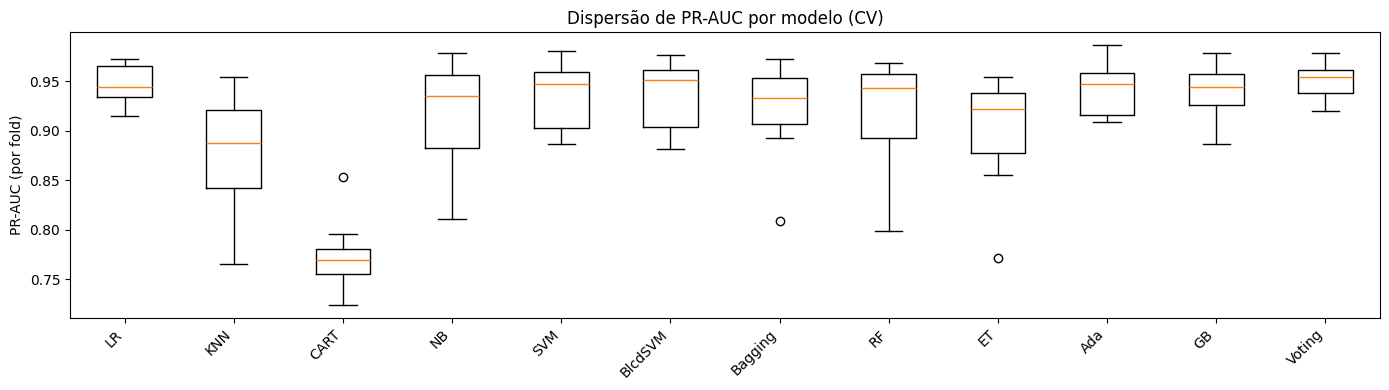

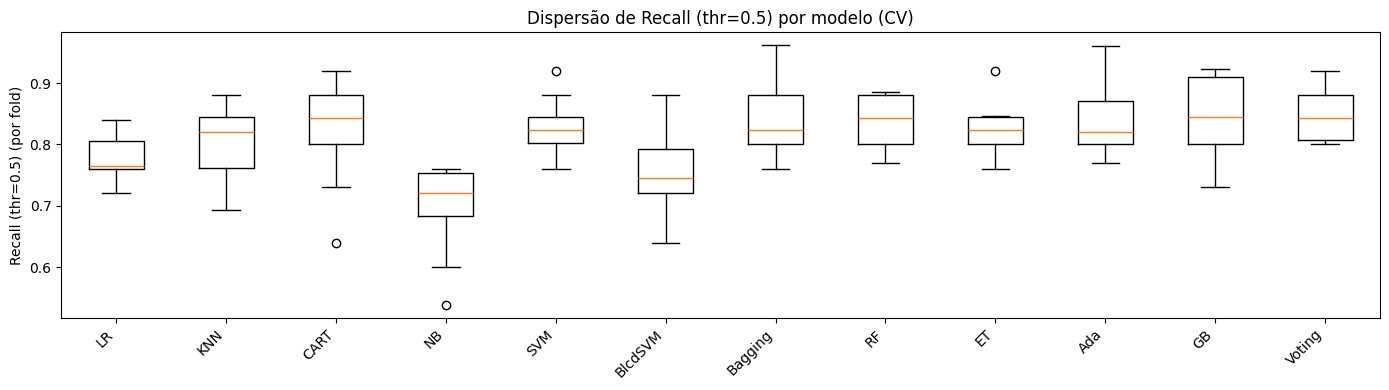

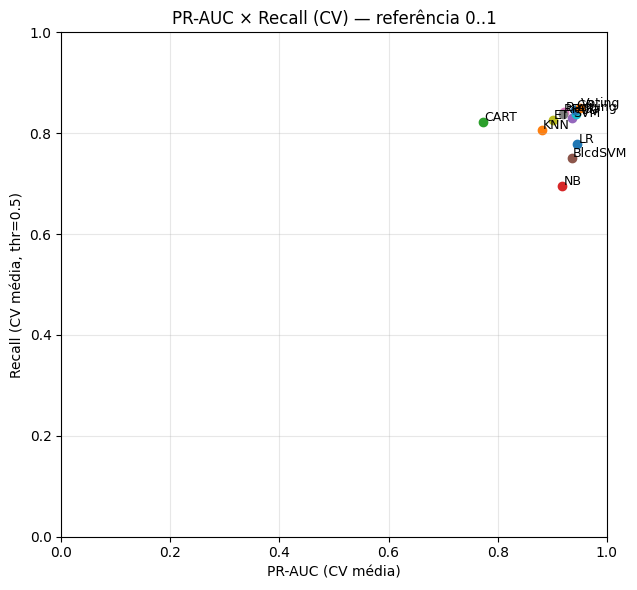

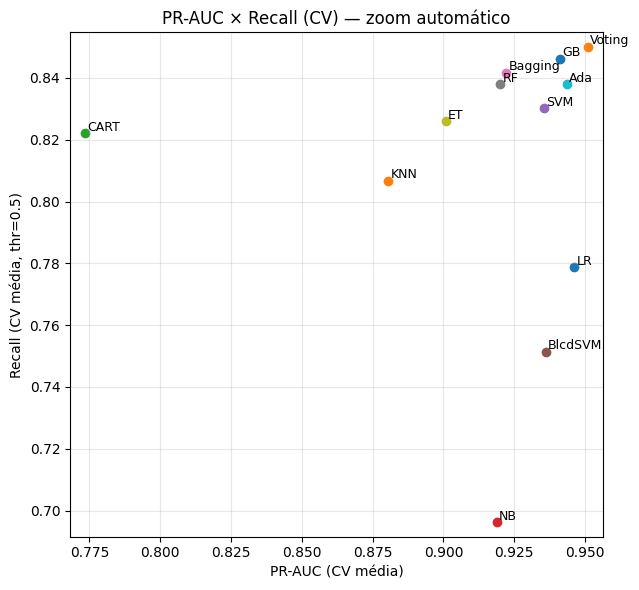

In [35]:
# 13.5) PR-AUC x Recall

# nomes dos modelos na mesma ordem usada na comparação
names = [name for name, _ in models]

def boxplot_metric(metric_key, pretty_label):
    """Boxplot por modelo usando os scores por fold salvos em fold_scores."""
    data = [fold_scores[metric_key][n] for n in names]
    plt.figure(figsize=(14,4))
    plt.boxplot(data, labels=names)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(f"{pretty_label} (por fold)")
    plt.title(f"Dispersão de {pretty_label} por modelo (CV)")
    plt.tight_layout()
    plt.show()

# Boxplots de PR-AUC e Recall (threshold 0.5)
boxplot_metric("average_precision", "PR-AUC")
boxplot_metric("recall", "Recall (thr=0.5)")

# Dispersão PR-AUC × Recall (CV) com referência 0..1 e zoom automático
def plot_prauc_recall_scatter(cv_table, zoom=True, margin=0.03):
    df = cv_table[["modelo","average_precision_mean","recall_mean"]].copy()

    # 1) Referência 0..1
    plt.figure(figsize=(6.5,6))
    for _, r in df.iterrows():
        plt.scatter(r["average_precision_mean"], r["recall_mean"])
        plt.text(r["average_precision_mean"]+0.002, r["recall_mean"]+0.002, r["modelo"], fontsize=9)
    plt.xlabel("PR-AUC (CV média)")
    plt.ylabel("Recall (CV média, thr=0.5)")
    plt.title("PR-AUC × Recall (CV) — referência 0..1")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    if not zoom:
        return

    # 2) Zoom automático na “nuvem”
    xmin = df["average_precision_mean"].min()
    xmax = df["average_precision_mean"].max()
    ymin = df["recall_mean"].min()
    ymax = df["recall_mean"].max()
    xr = max(xmax - xmin, 1e-6)
    yr = max(ymax - ymin, 1e-6)

    xmin = max(0.0, xmin - margin*xr); xmax = min(1.0, xmax + margin*xr)
    ymin = max(0.0, ymin - margin*yr); ymax = min(1.0, ymax + margin*yr)

    plt.figure(figsize=(6.5,6))
    for _, r in df.iterrows():
        plt.scatter(r["average_precision_mean"], r["recall_mean"])
        plt.text(r["average_precision_mean"]+0.0008, r["recall_mean"]+0.0008, r["modelo"], fontsize=9)
    plt.xlabel("PR-AUC (CV média)")
    plt.ylabel("Recall (CV média, thr=0.5)")
    plt.title("PR-AUC × Recall (CV) — zoom automático")
    plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# chama o scatter (com zoom)
plot_prauc_recall_scatter(cv_table, zoom=True, margin=0.03)


## Otimização de hiperparâmetros e escolha do ensemble

Com base nos resultados de CV, adota-se um **Voting (soft)** combinando **Regressão Logística + SVM (RBF/Linear) + Gradient Boosting**.  
Justificativa: modelos com **viés/variância distintos** tendem a se complementar; `soft voting` pondera as **probabilidades** (não apenas rótulos), beneficiando a **área sob a curva de precisão-revocação**.

O **GridSearchCV** (K=10, _n_jobs=-1_) busca um conjunto **enxuto e plausível** de hiperparâmetros:
- **LR**: penalização `l2` e escala **C** (força da regularização);
- **SVM**: `kernel ∈ {linear, rbf}` e **C**;
- **GB**: número de árvores, `learning_rate` e profundidade máxima;
- **weights** do ensemble (pesos relativos de cada base).
O **critério de seleção** é **PR-AUC (average precision)**, alinhado à prioridade do problema.

Após a busca, o melhor `Pipeline` é re-ajustado no treino completo e segue para a **avaliação final no TEST**, onde são reportadas **PR-AUC/ROC-AUC** e métricas no **limiar padrão (0.5)**, além do **Top-k%** (útil para priorização de intervenções).

In [36]:
# 13.6) Voting (LR + GB + SVM) — GridSearchCV com tempo de execução

voting_lgbs = VotingClassifier(
    estimators=[
        ('logistic', LogisticRegression(max_iter=1000, class_weight="balanced", random_state=SEED)),
        ('gb',       GradientBoostingClassifier(random_state=SEED)),
        ('svm',      SVC(probability=True, class_weight="balanced", random_state=SEED)),
    ],
    voting='soft'
)

pipe_voting_lgbs = Pipeline([
    ("prep", preprocess),
    ("clf",  voting_lgbs)
])

param_grid_lgbs = {
    "clf__logistic__penalty": ["l2"],
    "clf__logistic__C": [0.3, 1.0, 3.0],
    "clf__gb__n_estimators": [100, 200],
    "clf__gb__learning_rate": [0.05, 0.1],
    "clf__gb__max_depth": [2, 3],
    "clf__svm__kernel": ["linear", "rbf"],
    "clf__svm__C": [0.5, 1.0, 3.0],
    "clf__weights": [
        (1,1,1), (2,1,1), (1,2,1), (1,1,2),
        (2,2,1), (2,1,2), (1,2,2)
    ],
}

grid_voting_lgbs = GridSearchCV(
    estimator=pipe_voting_lgbs,
    param_grid=param_grid_lgbs,
    scoring="average_precision",  # PR-AUC
    cv=kfold,
    n_jobs=-1,
    refit=True,
    verbose=0,
    return_train_score=False
)

# --- estimativa de esforço ---
n_combos = len(list(ParameterGrid(param_grid_lgbs)))
try:
    n_folds = kfold.get_n_splits()
except:
    n_folds = 5
print(f"Combinações no grid: {n_combos} | Folds: {n_folds} | Total de fits (aprox): {n_combos*n_folds}")

# --- cronômetro ---
t0 = time.time()
grid_voting_lgbs.fit(X_train, y_train)
t1 = time.time()

print("Voting (LR+GB+SVM) — melhor PR-AUC (CV): {:.4f}".format(grid_voting_lgbs.best_score_))
print("Melhores hiperparâmetros:")
for k, v in grid_voting_lgbs.best_params_.items():
    print("  ", k, "=", v)

elapsed = t1 - t0
print(f"Tempo total do GridSearch: {elapsed:.1f}s (~{elapsed/60:.1f} min)")

best_voting = grid_voting_lgbs.best_estimator_


Combinações no grid: 1008 | Folds: 10 | Total de fits (aprox): 10080
Voting (LR+GB+SVM) — melhor PR-AUC (CV): 0.9539
Melhores hiperparâmetros:
   clf__gb__learning_rate = 0.1
   clf__gb__max_depth = 2
   clf__gb__n_estimators = 100
   clf__logistic__C = 3.0
   clf__logistic__penalty = l2
   clf__svm__C = 3.0
   clf__svm__kernel = rbf
   clf__weights = (2, 2, 1)
Tempo total do GridSearch: 2827.2s (~47.1 min)


## Avaliação final no conjunto de teste (thr=0,5) e métrica operacional Top-k
Reporta-se o desempenho do comitê escolhido (**Voting: LR + GB + SVM**) no **conjunto de teste**.
São calculadas: **PR-AUC** (métrica principal por refletir a qualidade do ranqueamento com foco na classe positiva), **ROC-AUC** e, com limiar fixo **0,5**, **Precision**, **Recall** e **F1**.
Adicionalmente, mede-se **Recall@Top-k%** e **Precision@Top-k%** (k=15%), alinhadas ao cenário em que somente o topo do ranqueamento recebe intervenção.

**Notas de interpretação**
- **PR-AUC** resume bem o ranqueamento quando há custos assimétricos.
- **Recall** é crítico porque **FN** significam alunos que podem evadir sem atenção.
- **Top-k** traduz a **capacidade operacional** (atuar em um subconjunto do topo).
- O limiar **0,5** é o padrão reportado; quando necessário, pode-se **calibrar em validação** para maximizar Recall sob uma Precision mínima — sem re-treinar o modelo nem inspecionar o teste.


In [37]:
# 13.7) Avaliação final (thr=0.5) + Top-k no TEST

try:
    K_PCT = float(TOPK_PCT)
except NameError:
    K_PCT = 0.15  # 15%

def _topk_metrics(y_true, y_score, k_pct=K_PCT):
    y_true = np.asarray(y_true); y_score = np.asarray(y_score)
    n = len(y_true); k = max(1, int(np.ceil(k_pct * n)))
    idx = np.argsort(-y_score)[:k]
    tp = (y_true[idx] == 1).sum()
    rec = tp / (y_true == 1).sum()
    prec = tp / k
    return rec, prec, k

# Garante treino completo e avalia
best_voting.fit(X_train, y_train)
proba_test = best_voting.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

prauc = average_precision_score(y_test, proba_test)
roc   = roc_auc_score(y_test, proba_test)
prec  = precision_score(y_test, pred_test, zero_division=0)
rec   = recall_score(y_test, pred_test, zero_division=0)
f1    = f1_score(y_test, pred_test, zero_division=0)

r_atk, p_atk, k = _topk_metrics(y_test, proba_test, K_PCT)

print("[TEST] Avaliação final (thr=0.5)")
print(f"PR-AUC={prauc:.4f} | ROC-AUC={roc:.4f}")
print(f"Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f}")
print(f"Top-{int(K_PCT*100)}% (k={k}) -> Recall@k={r_atk:.4f} | Precision@k={p_atk:.4f}")

_ult_proba_test = proba_test
_ult_metrics = {
    "modelo": "Voting(LR+GB+SVM)",
    "thr": 0.5,
    "PR_AUC": float(prauc),
    "ROC_AUC": float(roc),
    "Precision": float(prec),
    "Recall": float(rec),
    "F1": float(f1),
    f"Recall@Top{int(K_PCT*100)}%": float(r_atk),
    f"Precision@Top{int(K_PCT*100)}%": float(p_atk),
}


[TEST] Avaliação final (thr=0.5)
PR-AUC=0.9428 | ROC-AUC=0.8911
Precision=0.8814 | Recall=0.8125 | F1=0.8455
Top-15% (k=15) -> Recall@k=0.2344 | Precision@k=1.0000


## Curvas Precision–Recall e ROC no teste
As curvas complementam os valores agregados:
- **Curva PR**: evidencia a troca entre **Recall** e **Precision** ao variar o limiar; mais informativa quando a classe positiva é crítica.
- **Curva ROC**: mostra **TPR vs. FPR** ao longo dos limiares.
Os gráficos permitem verificar se há quedas abruptas e comparar o comportamento global do modelo além de um limiar específico.


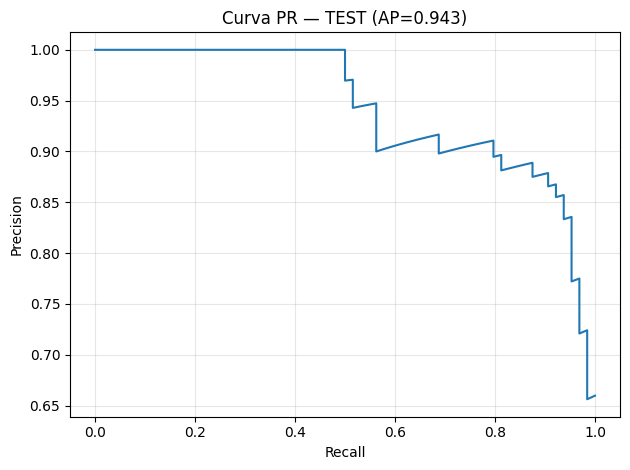

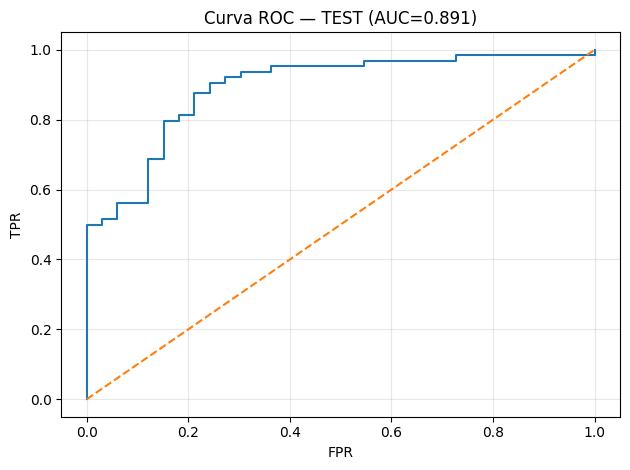

In [38]:
# 13.8) Curvas PR e ROC (TEST)

p, r, th = precision_recall_curve(y_test, _ult_proba_test)
plt.figure()
plt.plot(r, p)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Curva PR — TEST (AP={_ult_metrics['PR_AUC']:.3f})")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(y_test, _ult_proba_test)
plt.figure()
plt.plot(fpr, tpr); plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title(f"Curva ROC — TEST (AUC={_ult_metrics['ROC_AUC']:.3f})")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


## Estabilidade do pipeline final (3x CV=5 no treino)
Valida a **robustez** do pipeline repetindo **validação cruzada estratificada (K=5)** sob **três sementes** distintas.  
Reporta-se média e desvio-padrão de **PR-AUC** e **Recall (thr=0,5)**. Baixa variância indica estabilidade do processo e menor sensibilidade a flutuações amostrais.


In [39]:
# 13.9) Robustez: estabilidade do modelo final com 3 repetições de CV=5 (sem Grid)

seeds = [SEED, SEED+1, SEED+2]
scores_ap, scores_rec = [], []

for s in seeds:
    kf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=s)
    ap  = cross_val_score(best_voting, X_train, y_train, cv=kf5, scoring="average_precision", n_jobs=-1)
    rc  = cross_val_score(best_voting, X_train, y_train, cv=kf5, scoring="recall", n_jobs=-1)
    scores_ap.append(ap); scores_rec.append(rc)
    print(f"seed={s} | PR-AUC: {ap.mean():.4f} ± {ap.std():.4f} | Recall(thr=0.5): {rc.mean():.4f} ± {rc.std():.4f}")

ap_all  = np.concatenate(scores_ap)
rec_all = np.concatenate(scores_rec)
print(f"\nResumo (3×CV=5): PR-AUC {ap_all.mean():.4f} ± {ap_all.std():.4f} | Recall {rec_all.mean():.4f} ± {rec_all.std():.4f}")


seed=42 | PR-AUC: 0.9482 ± 0.0152 | Recall(thr=0.5): 0.8302 ± 0.0502
seed=43 | PR-AUC: 0.9468 ± 0.0201 | Recall(thr=0.5): 0.8227 ± 0.0804
seed=44 | PR-AUC: 0.9453 ± 0.0211 | Recall(thr=0.5): 0.8301 ± 0.0588

Resumo (3×CV=5): PR-AUC 0.9468 ± 0.0190 | Recall 0.8277 ± 0.0645


### Sanidade entre CV e Teste

O melhor **PR-AUC (CV)** do GridSearch foi ≈ **0,9538**, enquanto no **teste** obtivemos ≈ **0,9428**.  
A diferença absoluta (~**0,011**) está **dentro do desvio-padrão** medido nas repetições (13.9: **PR-AUC 0,9468 ± 0,0191**).  
Isso indica **consistência** entre validação e teste, sem evidência de degradação fora do esperado por variância de amostragem.


## Interpretação por Permutation Importance (teste)
A **Permutation Importance** estima a queda de **PR-AUC** ao embaralhar cada atributo, medindo sua contribuição marginal.  
São exibidas:
1) Importâncias nas **colunas transformadas** (após one-hot/escala);  
2) Importâncias **agregadas por atributo base** (soma das dummies de uma mesma coluna original).  
O resultado orienta leitura substantiva e priorização de coleta/manutenção de dados.


In [40]:
# 13.10) Permutation Importance (TEST) — interpretação

imp = permutation_importance(
    best_voting, X_test, y_test,
    n_repeats=10, random_state=SEED, scoring="average_precision"
)

prep = best_voting.named_steps["prep"]
try:
    feat_names = list(prep.get_feature_names_out())
except Exception:
    Z = prep.transform(X_train.iloc[:5])
    feat_names = [f"feat_{i}" for i in range(Z.shape[1])]

pi_df = pd.DataFrame({
    "feature_transformed": feat_names[:len(imp.importances_mean)],
    "perm_importance": imp.importances_mean[:len(feat_names)]
}).sort_values("perm_importance", ascending=False)

print("Permutation importance (TEST) — top 25 (transformadas):")
display(pi_df.head(25))

def _base_col(name):
    return name.split("_")[0]

pi_df["feature_base"] = pi_df["feature_transformed"].map(_base_col)
pi_agg = pi_df.groupby("feature_base", as_index=False)["perm_importance"].sum() \
              .sort_values("perm_importance", ascending=False)

print("Permutation importance agregada por coluna base (top 20):")
display(pi_agg.head(20))

_pi_det_test = pi_df.copy()
_pi_agg_test = pi_agg.copy()


Permutation importance (TEST) — top 25 (transformadas):


,feature_transformed,perm_importance
12,modalidadeCota_Ampla Concorrência,0.0358
2,pct_reprov_ate_N,0.0243
11,notaEnem,0.0209
5,pct_concl_obrigatorias_ate_N,0.0205
1,qtd_reprov_ate_N,0.0162
4,qtd_concl_obrigatorias_ate_N,0.0137
3,media_notas_ate_N,0.0127
0,qtd_matriculas_ate_N,0.0054
7,qtd_notas_baixas_lt3_ate_N,0.0051
13,modalidadeCota_Escolar,0.0051


Permutation importance agregada por coluna base (top 20):


,feature_base,perm_importance
3,pct,0.0496
1,modalidadeCota,0.0409
4,qtd,0.0405
2,notaEnem,0.0209
0,media,0.0127


## Reprodutibilidade e decisão sobre seleção de atributos
- **Reprodutibilidade.** Todo o fluxo usa **pipelines** com `ColumnTransformer` (imputação/codificação dentro dos folds, evitando vazamento), **seeds** fixas e registro do **tempo/combinações** no GridSearch. As saídas (métricas finais, top-k e importâncias) foram salvas em CSV para auditoria e reuso.

## Salvamento de artefatos de avaliação
Persistem-se:
- **Métricas finais (teste)** em CSV;
- **Importâncias** (detalhadas e agregadas) em CSV;
- **Lista Top-k do teste** (ids e escores) para auditoria e simulações operacionais.  
Esses artefatos permitem reprodutibilidade, rastreabilidade e análise externa sem reexecutar o notebook.

In [41]:
# 13.11) Salvar artefatos

df_metrics_final = pd.DataFrame([_ult_metrics])
df_metrics_final.to_csv("resultados_finais_test.csv", index=False)
print("Métricas finais salvas em: resultados_finais_test.csv")
display(df_metrics_final)

_pi_det_test.to_csv("perm_importance_transformadas_test.csv", index=False)
_pi_agg_test.to_csv("perm_importance_agregada_test.csv", index=False)
print("Importâncias salvas em: perm_importance_transformadas_test.csv / perm_importance_agregada_test.csv")

# Exporta Top-k do TEST (se houver aluno_id)
try:
    k = max(1, int(np.ceil((0.15 if 'K_PCT' not in globals() else K_PCT) * len(X_test))))
    top_idx = np.argsort(-_ult_proba_test)[:k]
    idx_labels = X_test.iloc[top_idx].index

    if "aluno_id" in df.columns:
        top_ids = df.loc[idx_labels, ["aluno_id", "label"]].copy()
        top_ids["score"] = _ult_proba_test[top_idx]
        top_ids = top_ids.sort_values("score", ascending=False)
        top_ids.to_csv("topk_test_alunos.csv", index=False)
        print(f"Top-{int((0.15 if 'K_PCT' not in globals() else K_PCT)*100)}% do TEST salvo em: topk_test_alunos.csv")
        display(top_ids.head(10))
    else:
        top_stub = pd.DataFrame({
            "index": idx_labels,
            "label": y_test.loc[idx_labels].values,
            "score": _ult_proba_test[top_idx]
        }).sort_values("score", ascending=False)
        top_stub.to_csv("topk_test_indices.csv", index=False)
        print("topk_test_indices.csv salvo (sem aluno_id).")
        display(top_stub.head(10))
except Exception as e:
    print("Não foi possível exportar Top-k (detalhe):", e)


Métricas finais salvas em: resultados_finais_test.csv


,modelo,thr,PR_AUC,ROC_AUC,Precision,Recall,F1,Recall@Top15%,Precision@Top15%
0,Voting(LR+GB+SVM),0.5000,0.9428,0.8911,0.8814,0.8125,0.8455,0.2344,1.0000


Importâncias salvas em: perm_importance_transformadas_test.csv / perm_importance_agregada_test.csv
Top-15% do TEST salvo em: topk_test_alunos.csv


,aluno_id,label,score
455,2338,1.0000,0.9835
287,1813,1.0000,0.9821
306,1848,1.0000,0.9817
432,2245,1.0000,0.9814
419,2152,1.0000,0.9805
217,1681,1.0000,0.9801
370,1996,1.0000,0.9782
213,1670,1.0000,0.9763
452,2332,1.0000,0.9755
267,1772,1.0000,0.9748


## EDA pontual: faltantes e correlação numérica
Antes de propor podas, apresenta-se um retrato dos **faltantes por coluna**, a **matriz de correlação (Pearson)** entre variáveis numéricas e a **correlação absoluta com o rótulo**.  
Esse diagnóstico identifica possíveis **redundâncias** e **sinais espúrios** sem aplicar filtragens agressivas.


%% de NA por coluna (top 20):


,NA_%
notaEnem,30.5000
qtd_matriculas_ate_N,0.0000
pct_reprov_ate_N,0.0000
media_notas_ate_N,0.0000
qtd_concl_obrigatorias_ate_N,0.0000
qtd_reprov_ate_N,0.0000
pct_concl_obrigatorias_ate_N,0.0000
qtd_adiantadas_ate_N,0.0000
qtd_notas_baixas_lt5_ate_N,0.0000
qtd_notas_baixas_lt3_ate_N,0.0000


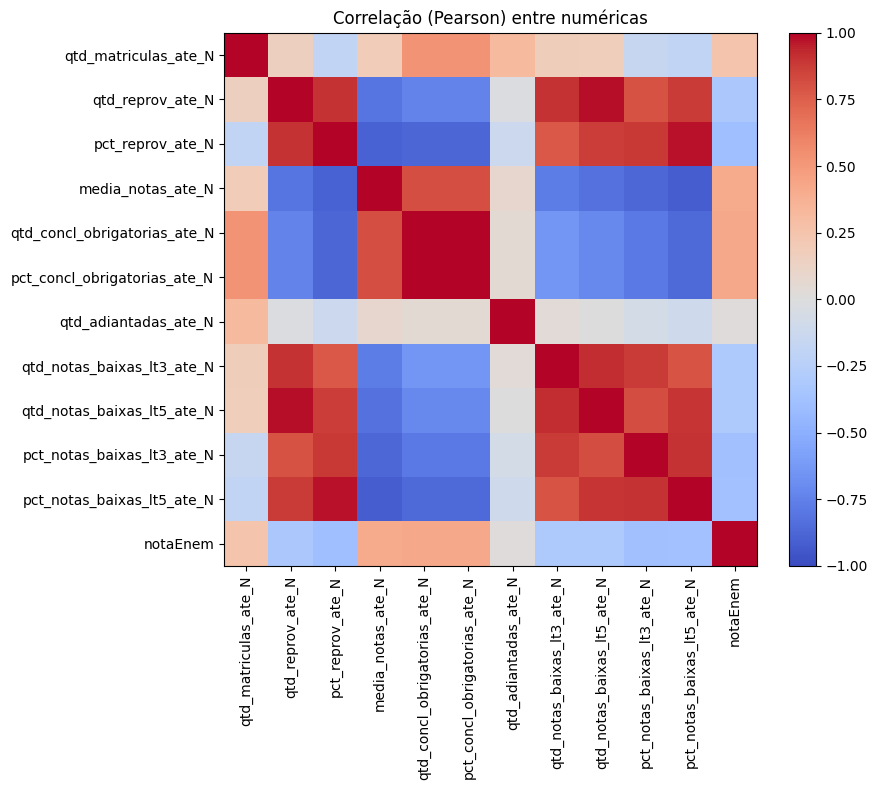

Correlação (abs) com o rótulo (top 20):


,corr_with_label
qtd_concl_obrigatorias_ate_N,-0.5536
pct_concl_obrigatorias_ate_N,-0.5536
pct_reprov_ate_N,0.5209
pct_notas_baixas_lt5_ate_N,0.5052
media_notas_ate_N,-0.4980
qtd_reprov_ate_N,0.4734
qtd_notas_baixas_lt5_ate_N,0.4556
pct_notas_baixas_lt3_ate_N,0.4488
qtd_notas_baixas_lt3_ate_N,0.3979
qtd_matriculas_ate_N,-0.2139


In [42]:
# 13.12) EDA: faltantes + correlação numérica + correlação com o rótulo

na_pct = X.isna().mean().sort_values(ascending=False) * 100
print("%% de NA por coluna (top 20):")
display(na_pct.head(20).round(2).to_frame("NA_%"))

num_cols_all = X.select_dtypes(include="number").columns.tolist()
corr_mat = X[num_cols_all].corr().fillna(0.0)

plt.figure(figsize=(10,8))
im = plt.imshow(corr_mat, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_cols_all)), num_cols_all, rotation=90)
plt.yticks(range(len(num_cols_all)), num_cols_all)
plt.title("Correlação (Pearson) entre numéricas")
plt.tight_layout(); plt.show()

y_numeric = y.astype(float)
corr_with_y = {}
for c in num_cols_all:
    col = X[c].astype(float)
    m = np.corrcoef(col.fillna(col.median()), y_numeric)[0,1]
    corr_with_y[c] = m

corr_with_y = pd.Series(corr_with_y).sort_values(key=lambda s: s.abs(), ascending=False)
print("Correlação (abs) com o rótulo (top 20):")
display(corr_with_y.head(20).to_frame("corr_with_label"))


## Poda leve de multicolinearidade (|ρ| ≥ 0,95)
Remove-se, de pares altamente correlacionados (|ρ| ≥ 0,95), a variável com **menor correlação absoluta com o rótulo**, mantendo a mais informativa.  
Trata-se de uma intervenção **conservadora** para reduzir redundância extrema sem comprometer o sinal preditivo.


In [43]:
# 13.13) Poda leve de multicolinearidade numérica (|ρ|>0.95)

high = 0.95
to_drop = set()
checked = set()

for i, c1 in enumerate(num_cols_all):
    if c1 in to_drop:
        continue
    for j in range(i+1, len(num_cols_all)):
        c2 = num_cols_all[j]
        if (c1, c2) in checked or (c2, c1) in checked:
            continue
        checked.add((c1, c2))
        rho = corr_mat.loc[c1, c2]
        if abs(rho) >= high:
            keep = c1 if abs(corr_with_y.get(c1, 0)) >= abs(corr_with_y.get(c2, 0)) else c2
            drop = c2 if keep == c1 else c1
            to_drop.add(drop)

to_drop = sorted(to_drop)
print(f"Drop de {len(to_drop)} colunas numéricas muito correlacionadas:")
print(to_drop)

X_train_red = X_train.drop(columns=to_drop, errors="ignore").copy()
X_test_red  = X_test.drop(columns=to_drop, errors="ignore").copy()

print("Shapes: X_train ->", X_train.shape, "| X_train_red ->", X_train_red.shape)
print("Shapes: X_test  ->", X_test.shape,  "| X_test_red  ->", X_test_red.shape)


Drop de 3 colunas numéricas muito correlacionadas:
['pct_concl_obrigatorias_ate_N', 'pct_notas_baixas_lt5_ate_N', 'qtd_notas_baixas_lt5_ate_N']
Shapes: X_train -> (385, 14) | X_train_red -> (385, 11)
Shapes: X_test  -> (97, 14) | X_test_red  -> (97, 11)


## Experimento de seleção de atributos (CV=5)
Compara-se o **baseline** com três estratégias dentro do pipeline (sem vazamento):
1) **SelectFromModel (L1)** com Regressão Logística;  
2) **SelectFromModel (ExtraTrees)**;  
3) **SelectKBest** por **mutual information** (k ajustado à dimensão pós-transformação).  
A comparação usa **PR-AUC (CV=5)**. A recomendação é adotar seleção apenas se houver **ganho consistente** sem **piora relevante de Recall**, privilegiando simplicidade e robustez.


In [44]:
# 13.14) Experimento FS (CV=5): L1, ExtraTrees e KBest (mutual info)

kf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Baseline
pipe_baseline = best_voting  # Pipeline(prep -> voting) já configurado/hparametrizado

# 1) L1 (LogReg) — zera coeficientes
pipe_l1 = Pipeline([
    ("prep", best_voting.named_steps["prep"]),
    ("select", SelectFromModel(
        LogisticRegression(penalty="l1", solver="liblinear", class_weight="balanced", random_state=SEED),
        threshold="median"
    )),
    ("clf", best_voting.named_steps["clf"])
])

# 2) ExtraTrees — modelo não-linear como seletor
pipe_et = Pipeline([
    ("prep", best_voting.named_steps["prep"]),
    ("select", SelectFromModel(
        ExtraTreesClassifier(n_estimators=300, random_state=SEED, n_jobs=-1),
        threshold="median"
    )),
    ("clf", best_voting.named_steps["clf"])
])

# 3) KBest (mutual information) — seleciona top-k (percentil ~50%)
# Para evitar descobrir o #features pós-transform, ajustamos k dinamicamente no 1º fit.
# Implemento com um pequeno truque: rodo uma passada para descobrir dimensão e recalculo k.

Z = best_voting.named_steps["prep"].fit_transform(X_train, y_train)
k_auto = max(5, min(Z.shape[1] // 2, 40))  # entre 5 e 40, ~50% por padrão
pipe_kbest = Pipeline([
    ("prep", best_voting.named_steps["prep"]),
    ("select", SelectKBest(score_func=mutual_info_classif, k=k_auto)),
    ("clf", best_voting.named_steps["clf"])
])

def _cv_ap(pipe, Xt, yt, desc):
    ap = cross_val_score(pipe, Xt, yt, cv=kf5, scoring="average_precision", n_jobs=-1)
    print(f"{desc:22s} — PR-AUC (CV5): {ap.mean():.4f} ± {ap.std():.4f}")
    return ap

print("Comparação de PR-AUC (CV=5) com e sem FS:")
ap_base = _cv_ap(pipe_baseline, X_train, y_train, "Baseline")
ap_l1   = _cv_ap(pipe_l1,       X_train, y_train, "L1 SelectFromModel")
ap_et   = _cv_ap(pipe_et,       X_train, y_train, "ExtraTrees SelectFromModel")
ap_kb   = _cv_ap(pipe_kbest,    X_train, y_train, "KBest (mutual_info)")

print("\nDecisão sugerida:")
print("- Adote FS somente se houver ganho consistente em PR-AUC (sem piorar muito Recall).")
print("- Caso contrário, mantenha o baseline (simples e robusto).")


Comparação de PR-AUC (CV=5) com e sem FS:
Baseline               — PR-AUC (CV5): 0.9482 ± 0.0152
L1 SelectFromModel     — PR-AUC (CV5): 0.9452 ± 0.0152
ExtraTrees SelectFromModel — PR-AUC (CV5): 0.9408 ± 0.0121
KBest (mutual_info)    — PR-AUC (CV5): 0.9242 ± 0.0114

Decisão sugerida:
- Adote FS somente se houver ganho consistente em PR-AUC (sem piorar muito Recall).
- Caso contrário, mantenha o baseline (simples e robusto).


# Conclusão e principais decisões

**Modelo escolhido.** Após comparar baselines em validação cruzada, os melhores modelos apresentaram **PR-AUC** muito próximos, mas diferenças relevantes de **Recall** (custo de FN). Para conciliar **ranqueamento global** (PR-AUC alto) com **cobertura** (Recall elevado), optou-se por um **comitê Voting (soft)** combinando três famílias complementares:
- **Linear — Regressão Logística:** capta tendência global e fornece probabilidades bem calibradas;
- **Margem — SVM (RBF):** fronteiras suaves, útil quando há sobreposição entre classes;
- **Árvore/Boosting — Gradient Boosting:** captura não-linearidades e interações entre atributos.

A árvore simples (CART) normalmente usada foi substituída por **Gradient Boosting** por desempenho superior no conjunto (melhor PR-AUC e Recall, com menor risco de alta variância de uma árvore única). Os **hiperparâmetros** e **pesos do ensemble** foram ajustados via **GridSearchCV**, usando **PR-AUC** como métrica-alvo (mais informativa que ROC-AUC em cenários com assimetria de custos e atuação no topo do ranking).

**Avaliação e métrica operacional.** Além de PR-AUC/ROC-AUC, reportaram-se métricas no **limiar padrão (0,5)** e as métricas **Recall@Top-k%** e **Precision@Top-k%** (k=15%) para refletir a capacidade operacional de intervenção apenas no topo. Quando necessário, o limiar pode ser **calibrado em validação** para maximizar Recall sob uma Precision mínima, sem refazer o treinamento.

**Preparação e boas práticas.** O fluxo usa **pipelines** (`ColumnTransformer` com imputação/escala/one-hot) para evitar vazamento, **seeds** fixas e registro de **tempo/combinações** no grid. Colunas **constantes** foram removidas e aplicou-se **poda leve de multicolinearidade**; técnicas de *feature selection* (L1, ExtraTrees, KBest) foram testadas, mas **não superaram o baseline**, preservando a solução mais simples e robusta.

**Limitações e próximos passos.** O conjunto é moderado em tamanho; ampliar dados (coortes/semestres) pode reduzir variância. Como evolução, considerar **calibração de probabilidades**, **thresholds específicos por recurso operacional**, e análise de **custo-benefício** (FP vs. FN) para alinhar a política de acionamento às metas da coordenação.
